# Problem Set 4

**Task**: The problem set comprises one point only:

1.  Use Python to estimate the extent of triadic closure in a real-world, one-mode network.


**Context**:

- the Kossinets-Watts' model (see [week 4
  slideshow](https://github.com/simoneSantoni/net-analysis-smm638/blob/master/week4/slideshow_1.ipynb))
  offers the analytical framework to investigate triadic closure
- the key outcome of the submission is a chart that closely resembles what
  reported in the [week 4
  slideshow](https://github.com/simoneSantoni/net-analysis-smm638/blob/master/week4/slideshow_1.ipynb),
  "Triadic closure in an email exchange network" slide
- the email exchange dataset collected by the SNAP crowd is a suited setting to address the problem:
   * location: https://snap.stanford.edu/data/email-Eu-core-temporal.html
   * data come from a large European research institution. Here's a quote from the SNAP website: "We have anonymized information about all incoming and outgoing email between members of the research institution. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. A directed edge (u, v, t) means that person u sent an e-mail to person v at time t. A separate edge is created for each recipient of the e-mail. We also have four sub-networks corresponding to the communication between members of four different departments at the institution. Node IDs in the sub-networks do not correspond to the same node ID in the entire network."

**Submission**: Submit your solution via email to simone.santoni.1@city.ac.uk.
Late submissions (> November 18, 2020) may not be considered for the in-class
presentations.


 **Evaluating closure ― Kossinets & Watts' procedure**
We can address these questions empirically using network data as follows:

- We take two snapshots of the network at different times.
- For each $k$, we identify all pairs of nodes who have exactly $k$ friends in common in the first snapshot, but who are not directly connected by an edge
- We define $T(k)$ to be the fraction of these pairs that have formed an edge by the time of the second snapshot. This is our empirical estimate for the probability that a link will form between two people with $k$ friends in common.
- We plot $T(k)$ as a function of $k$ to illustrate the effect of common friends on the formation of links.

# Import relevant libraries

In [1]:
import math
import pprint
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# setup pprint
pp = pprint.PrettyPrinter(width=100, compact=True)

# remove false-positive warning (chain_assignment)
pd.set_option('mode.chained_assignment', None)

# Load dataset
Dataset used in this problem set is: ([email-Eu-core-temporal.txt.gz](https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz))  

Dataset info:
- Dataset statistics (email-Eu-core-temporal)
    - Nodes	986
    - Temporal Edges 332334
    - Edges in static graph	24929
    - Time span	803 days

In [3]:
data = pd.read_csv('email-Eu-core-temporal.txt', sep = ' ', names = ['source', 'target', 'timestamp'])
data

,source,target,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


In [4]:
# Remove irrelevant data
data = data[data['timestamp'] <= data['timestamp'].iloc[-1]]

In [5]:
data

,source,target,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


# Kossinets & Watts' procedure

# Pre-processing

## Step1:
- We take two snapshots of the network at different times.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329910 entries, 0 to 332333
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   source     329910 non-null  int64
 1   target     329910 non-null  int64
 2   timestamp  329910 non-null  int64
dtypes: int64(3)
memory usage: 10.1 MB


In [7]:
# before snapshot: at timestamp < 8640000 (100days) 
snap1 = data[data['timestamp'] < 8640000]

# sort by source, target
snap1.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
snap1

,source,target,timestamp
49502,0,6,8167849
50211,0,6,8245817
1911,0,118,212684
49322,0,470,8157065
38823,0,732,6689158
...,...,...,...
37660,1004,977,5583912
42080,1004,977,7048494
48764,1004,977,8083620
49916,1004,977,8237184


In [8]:
# after snapshot: 200 days data (+100days from the first snap) 
snap2 = data[data['timestamp'] < 8640000*2]

# sort by source, target
snap2.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
snap2

,source,target,timestamp
49502,0,6,8167849
50211,0,6,8245817
69562,0,6,11172035
74464,0,6,11777490
78755,0,6,12381593
...,...,...,...
92527,1004,977,14135391
103583,1004,977,15756668
103674,1004,977,15757958
105546,1004,977,15870940


## Step 2:
- For each $k$, we identify all pairs of nodes who have exactly $k$ friends in common in the first snapshot, but who are not directly connected by an edge

In [9]:
def kossinets_watts(snap):
    
    # get all nodes in the snap
    source_set = set(snap['source'])
    target_set = set(snap['target'])
    node_list = list(set(snap['source']).union(set(snap['target'])))

    # get dictionary of nodes (keys) and their ties (values)
    # {`node` : [list of nodes it has interacted with],...}
    structure = {}
    for node in node_list:
        if node in snap['source']:
            set1 = set(snap[snap['source'] == node]['target'].unique())
        if node in snap['target']:
            set2 = set(snap[snap['target'] == node]['source'].unique())
        to_append = list(set.intersection(set1, set2))
        structure[node] = to_append

    # preparation to create a nested dictionary
    nested_dict = {}

    # loop over all the nodes
    for source in node_list:
        temp_dict = {}
        for target in node_list:
            # to avoid duplicated data, only compute the cases where target > source
            if target > source:
                # if there is no edge between the two nodes
                if target not in structure[source]:
                    # calculate mutual ties
                    num_mutual = len(set.intersection(set(structure[source]), set(structure[target])))
                    # add the info to `temp_dict`
                    if num_mutual in temp_dict.keys():
                        temp_dict[num_mutual].append(target)
                    else: 
                        temp_dict[num_mutual] = [target]

        # store `temp_dict` in `nested_dict`            
        nested_dict[source] = temp_dict    
        
    return nested_dict, structure

In [10]:
# variable info:
# `result`: nested dict -> see above
# `structure`: {`node` : [list of nodes it has interacted with],...}
snap1_result, snap1_structure = kossinets_watts(snap1)
snap2_result, snap2_structure = kossinets_watts(snap2)

In [11]:
pp.pprint(snap1_structure)

{0: [732, 470, 118],
 1: [324, 309, 310],
 2: [769, 135, 272, 17, 532, 790, 923, 283, 416, 38, 167, 168, 812, 52, 313, 956, 700, 61, 322, 840,
     586, 75, 715, 77, 846, 335, 983, 868, 231, 236, 749, 499, 500, 628, 629, 119, 891, 126],
 4: [371, 771, 214],
 5: [609, 135, 553, 107, 491, 175, 335, 275, 532, 724, 246, 506, 670, 607],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [923, 334],
 12: [870, 422, 680, 720, 406, 731],
 13: [738, 516, 743, 682, 239, 719, 532],
 14: [738, 644, 199, 1001, 173, 365, 783, 719, 657, 506, 724, 761, 118, 921, 410, 924, 702],
 15: [680, 406, 731, 422],
 16: [843, 716, 333, 718, 724, 502, 506, 732, 541, 127],
 17: [2, 165, 428, 915, 857],
 19: [716, 127],
 23: [],
 24: [647, 136, 267, 526, 142, 656, 530, 658, 280, 31, 160, 547, 685, 561, 739, 360, 493, 629, 630,
      631, 891],
 25: [672, 321, 704, 458, 844, 48, 383],
 26: [40],
 27: [],
 28: [987],
 29: [808, 333, 335, 48, 506],
 30: [256, 135, 648, 912, 166, 294, 168, 936, 942, 185, 313, 581, 472, 356,

 346: [],
 347: [933, 966, 168, 171, 590, 147, 308, 90, 926],
 350: [231],
 353: [185, 891, 190],
 355: [],
 356: [256, 772, 260, 517, 648, 528, 912, 157, 30, 159, 416, 166, 294, 168, 550, 684, 305, 52, 569,
       61, 573, 65, 586, 77, 334, 462, 718, 854, 472, 90, 602, 607, 868, 743, 112, 499, 500, 629,
       502, 120, 505, 765, 126],
 359: [],
 360: [160, 170, 493, 526, 569, 561, 530, 658, 629, 280, 697, 24],
 361: [],
 362: [672, 450, 605, 517, 135, 168, 909, 111, 528, 978, 984, 695, 280, 922, 957, 383],
 364: [],
 365: [118, 14],
 366: [],
 368: [879],
 369: [324, 535, 646, 168, 77, 951, 823, 444, 700, 62],
 370: [],
 371: [528, 4, 720],
 372: [934, 239, 595, 404, 572, 415],
 373: [],
 374: [105, 306, 953, 317],
 375: [],
 377: [522, 530, 159, 422, 423, 53, 696, 61, 65, 457, 716, 718, 724, 729, 731, 607, 866, 101, 246,
       630, 127],
 378: [],
 379: [272, 568, 662],
 380: [],
 381: [192, 643, 327, 107, 335, 783, 532, 506, 670],
 382: [],
 383: [388, 40, 765, 586, 362, 428, 589,

 737: [107, 175, 849, 275, 440],
 738: [644, 516, 134, 650, 13, 14, 654, 783, 921, 923, 541, 682, 427, 433, 951, 702, 837, 719, 850,
       214, 607, 231, 1001, 624, 761, 506],
 739: [65, 528, 915, 24, 731],
 740: [832, 322, 106, 879, 337, 788, 950, 157],
 741: [],
 742: [771, 900, 135, 272, 659, 159, 687, 306, 692, 443, 61, 65, 450, 835, 334, 214, 90, 863, 993,
       483, 229, 104, 749, 239, 765],
 743: [516, 13, 528, 912, 923, 542, 30, 546, 166, 550, 168, 684, 305, 956, 62, 704, 65, 333, 214,
       854, 472, 602, 859, 356, 868, 120, 506, 765],
 745: [],
 746: [966, 935, 135, 233, 812, 749, 334, 718, 692, 214, 502, 534, 90, 923],
 747: [],
 748: [577, 308, 926],
 749: [2, 264, 660, 540, 306, 692, 56, 569, 830, 191, 450, 75, 334, 718, 90, 987, 220, 607, 742,
       231, 746, 629, 502],
 752: [416, 644, 220, 253, 191],
 753: [],
 754: [866, 718, 272, 595, 127],
 758: [73, 844, 723, 918, 956],
 759: [74, 126, 166],
 761: [738, 866, 516, 327, 969, 650, 396, 14, 783, 881, 850, 532, 790, 

In [12]:
pp.pprint(snap1_result)

{0: {0: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
         34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 53, 56, 58, 59, 60, 61, 62, 64,
         65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 86, 87, 90, 91, 92, 95,
         96, 97, 98, 101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120,
         122, 124, 125, 126, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145,
         146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 164, 165, 166, 167,
         168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185, 186, 187, 188, 190, 191, 192,
         193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 214, 215,
         216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 239,
         240, 241, 242, 243, 245, 246, 248, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263,
  

         394, 395, 396, 397, 399, 400, 401, 402, 404, 406, 407, 408, 409, 411, 418, 420, 421, 422,
         423, 424, 426, 427, 429, 430, 431, 432, 433, 434, 436, 437, 438, 441, 442, 444, 446, 448,
         452, 453, 456, 457, 459, 461, 466, 467, 468, 470, 471, 473, 474, 475, 476, 477, 478, 481,
         482, 483, 485, 487, 488, 489, 492, 495, 497, 501, 504, 505, 508, 509, 510, 511, 512, 513,
         514, 515, 520, 523, 524, 527, 533, 538, 539, 544, 549, 551, 554, 556, 557, 559, 562, 563,
         564, 566, 571, 574, 576, 577, 578, 580, 582, 584, 588, 589, 590, 591, 593, 596, 597, 599,
         603, 606, 613, 614, 616, 618, 619, 622, 626, 627, 634, 637, 639, 640, 641, 644, 645, 646,
         647, 649, 652, 653, 654, 655, 656, 657, 659, 661, 669, 671, 673, 674, 676, 678, 681, 682,
         683, 686, 688, 690, 693, 694, 695, 697, 699, 701, 702, 705, 706, 707, 708, 709, 710, 711,
         713, 714, 719, 722, 723, 724, 727, 729, 731, 732, 734, 735, 737, 739, 741, 745, 747, 748,
         7

 6: {0: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34,
         35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 53, 56, 58, 59, 60, 61, 62, 64, 65,
         66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 86, 87, 90, 91, 92, 95, 96,
         97, 98, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119, 120, 122, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 164,
         165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185, 186, 187, 188,
         189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207,
         208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232,
         233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255,
         

         426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
         444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465,
         466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485,
         487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510,
         511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532,
         533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552,
         553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574,
         575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
         595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622,
         624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646,
         6

          870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890,
          891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918,
          920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942,
          944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967,
          968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988,
          990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 11: {0: [12, 13, 14, 15, 16, 17, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 39, 41,
          42, 44, 45, 46, 48, 49, 50, 52, 56, 58, 59, 60, 62, 64, 66, 67, 68, 69, 71, 72, 73, 74,
          76, 77, 78, 79, 82, 83, 84, 86, 87, 91, 92, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106,
          107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 124, 125, 126, 131, 132, 133,
          136, 137, 138, 139, 141

          240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260,
          263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285,
          290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 306, 307, 308, 309, 310, 311,
          313, 316, 317, 318, 319, 320, 321, 322, 323, 325, 326, 327, 329, 330, 331, 332, 334, 337,
          338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 359, 360, 361, 362, 364, 365, 366, 368,
          369, 370, 371, 373, 374, 375, 377, 378, 379, 380, 382, 383, 385, 386, 388, 389, 391, 392,
          393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 411, 414,
          415, 416, 418, 420, 421, 422, 423, 424, 426, 428, 429, 430, 431, 432, 434, 435, 436, 437,
          438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458,
          459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 473, 474, 475, 476, 477, 478,


          866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885,
          886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911,
          912, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938,
          939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963,
          966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986,
          987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
      1: [31, 65, 90, 92, 157, 159, 214, 280, 281, 493, 540, 563, 569, 584, 609, 707, 739, 790, 809,
          915, 951],
      2: [284, 377, 696, 720, 789]},
 16: {0: [17, 23, 24, 25, 26, 27, 28, 30, 34, 35, 36, 38, 39, 41, 42, 44, 45, 46, 48, 49, 50, 52,
          56, 58, 59, 60, 62, 64, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 79, 82, 83, 84, 86, 87,
          91, 92, 95, 96, 97, 98, 102, 103, 104, 105, 106, 110, 1

          118, 119, 122, 124, 125, 126, 127, 131, 132, 133, 134, 137, 138, 139, 144, 145, 146, 147,
          148, 149, 150, 151, 152, 153, 154, 157, 158, 161, 164, 166, 168, 171, 173, 174, 175, 176,
          179, 180, 181, 184, 185, 187, 191, 192, 193, 194, 195, 196, 198, 199, 201, 202, 203, 205,
          206, 208, 209, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232,
          233, 235, 236, 239, 240, 242, 243, 245, 246, 249, 250, 251, 252, 253, 254, 255, 257, 259,
          260, 263, 264, 268, 269, 270, 272, 273, 275, 276, 277, 278, 283, 284, 285, 291, 292, 293,
          294, 295, 297, 299, 302, 303, 304, 305, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319,
          320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 335, 337, 338, 339, 341,
          343, 346, 347, 350, 355, 359, 361, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375,
          378, 379, 380, 381, 382, 385, 386, 388, 389, 391, 393, 394, 395, 396, 397, 398, 399, 400,


          137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 157, 158,
          160, 161, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185,
          186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206,
          207, 208, 209, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232,
          233, 235, 236, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256,
          257, 259, 260, 263, 264, 267, 268, 269, 270, 273, 274, 275, 276, 277, 278, 280, 281, 283,
          284, 285, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309,
          310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331,
          332, 333, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361,
          362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382,


 29: {0: [30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 49, 50, 52, 53, 56, 58, 59, 60,
          61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 74, 75, 76, 77, 79, 82, 83, 84, 86, 87, 91, 92,
          95, 96, 97, 98, 101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 115, 116, 117, 120, 122,
          124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145,
          146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 160, 161, 164, 165, 166, 167, 168,
          170, 171, 174, 175, 176, 179, 180, 181, 185, 186, 187, 188, 190, 191, 194, 195, 196, 197,
          198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221,
          223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 239, 240, 241, 242, 243, 245, 246, 250,
          252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275,
          276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302,
   

          807, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830,
          831, 832, 833, 834, 835, 836, 837, 840, 841, 842, 844, 845, 846, 849, 850, 852, 853, 854,
          855, 859, 861, 863, 865, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
          882, 883, 884, 885, 886, 887, 889, 893, 894, 897, 898, 900, 901, 905, 907, 909, 910, 911,
          916, 918, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942,
          944, 945, 946, 947, 950, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970, 972, 973,
          975, 976, 978, 983, 984, 985, 986, 987, 988, 990, 993, 994, 995, 996, 997, 1002, 1003],
      1: [53, 67, 118, 149, 158, 160, 170, 171, 184, 185, 188, 190, 197, 228, 239, 273, 285, 290,
          301, 333, 338, 369, 383, 388, 401, 406, 409, 410, 415, 423, 433, 462, 470, 482, 493, 526,
          532, 538, 541, 547, 552, 553, 561, 580, 581, 599, 603, 605, 638, 656, 660, 680, 681, 683,
    

 35: {0: [36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 53, 56, 58, 59, 60, 61, 62, 64, 66,
          67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 86, 87, 91, 92, 95, 96, 97,
          98, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
          120, 122, 124, 125, 126, 127, 131, 132, 133, 134, 136, 137, 138, 139, 143, 144, 145, 146,
          147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 161, 164, 165, 166, 168, 170, 171, 173,
          174, 175, 176, 179, 180, 181, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196,
          197, 198, 199, 200, 201, 202, 203, 205, 206, 208, 209, 214, 215, 216, 217, 218, 219, 220,
          221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 239, 240, 241, 242, 243, 245,
          246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269,
          270, 272, 273, 275, 276, 277, 278, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297,
     

          568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 587, 588, 589, 591,
          592, 593, 594, 596, 597, 599, 602, 603, 605, 606, 613, 614, 616, 617, 618, 619, 622, 624,
          626, 627, 630, 631, 633, 634, 637, 639, 640, 641, 643, 645, 646, 647, 648, 649, 652, 653,
          654, 655, 656, 657, 658, 659, 661, 662, 664, 669, 670, 672, 673, 674, 676, 678, 679, 680,
          681, 682, 683, 684, 685, 686, 687, 688, 690, 693, 694, 696, 697, 698, 699, 701, 704, 705,
          707, 708, 709, 711, 714, 716, 722, 723, 727, 729, 732, 734, 735, 736, 737, 738, 739, 741,
          743, 745, 747, 748, 752, 753, 754, 758, 759, 761, 762, 764, 765, 767, 770, 773, 774, 775,
          777, 779, 780, 782, 783, 784, 789, 793, 794, 795, 796, 800, 801, 803, 804, 807, 808, 810,
          814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 833, 834, 835,
          836, 837, 838, 842, 844, 845, 847, 849, 850, 852, 853, 854, 855, 857, 858, 859, 861, 863,


 41: {0: [42, 44, 45, 46, 49, 50, 52, 53, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72,
          74, 75, 76, 77, 78, 79, 82, 83, 84, 86, 87, 90, 91, 92, 95, 96, 97, 98, 101, 102, 103,
          104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125,
          126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147,
          148, 149, 150, 151, 152, 153, 154, 157, 158, 160, 161, 164, 165, 166, 167, 168, 170, 171,
          173, 174, 175, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
          196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 215, 216, 217, 218, 219,
          220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 239, 240, 241, 242, 243,
          245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268,
          269, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294,
     

          448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468,
          469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489,
          491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513,
          514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535,
          537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556,
          557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
          578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
          599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627,
          628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
          650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672,


          350, 353, 355, 359, 360, 361, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377,
          378, 379, 380, 381, 382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399,
          400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 418, 420, 421, 422, 424,
          426, 427, 428, 429, 430, 431, 432, 433, 434, 436, 437, 438, 439, 440, 441, 442, 444, 446,
          447, 448, 449, 452, 453, 456, 457, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470,
          471, 472, 473, 474, 475, 476, 477, 478, 479, 482, 483, 485, 487, 488, 489, 491, 492, 493,
          495, 497, 501, 502, 504, 505, 508, 509, 510, 511, 512, 513, 514, 515, 516, 519, 520, 522,
          523, 524, 526, 527, 528, 531, 532, 533, 534, 537, 538, 539, 541, 543, 544, 546, 547, 548,
          549, 551, 552, 553, 554, 556, 557, 559, 561, 562, 563, 564, 566, 568, 571, 572, 573, 574,
          575, 576, 578, 581, 584, 585, 586, 587, 588, 589, 590, 591, 593, 594, 596, 597, 599, 602,


          953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976,
          977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001,
          1002, 1003, 1004]},
 52: {0: [53, 58, 59, 60, 62, 64, 67, 68, 69, 71, 72, 73, 76, 78, 79, 82, 84, 86, 87, 92, 95, 96,
          97, 98, 101, 102, 103, 105, 106, 110, 111, 113, 114, 115, 116, 117, 118, 122, 124, 125,
          131, 132, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 150, 152, 153, 154, 158,
          160, 161, 164, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 186, 188, 189, 190, 192,
          194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 215, 216, 217,
          218, 219, 221, 223, 226, 228, 230, 233, 235, 239, 240, 241, 242, 245, 246, 248, 249, 250,
          251, 252, 253, 254, 255, 257, 259, 263, 264, 268, 269, 270, 273, 274, 275, 276, 277, 281,
          284, 285, 291, 292, 293, 295, 297, 299, 301, 302, 303, 304, 307

          524, 526, 527, 532, 533, 537, 538, 539, 541, 543, 544, 546, 547, 548, 549, 552, 553, 554,
          556, 557, 558, 559, 561, 562, 564, 568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581,
          584, 585, 587, 588, 589, 591, 593, 594, 596, 597, 599, 602, 603, 605, 612, 613, 616, 618,
          619, 622, 626, 627, 628, 630, 631, 634, 637, 639, 640, 641, 643, 644, 645, 646, 647, 648,
          649, 652, 653, 654, 655, 656, 657, 658, 659, 661, 663, 664, 669, 670, 672, 673, 674, 676,
          678, 679, 680, 681, 682, 683, 684, 685, 686, 688, 690, 693, 694, 696, 697, 698, 699, 701,
          702, 704, 705, 706, 707, 708, 709, 711, 715, 719, 722, 723, 727, 729, 732, 734, 735, 736,
          737, 738, 740, 741, 745, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 765, 767, 770,
          773, 774, 775, 780, 782, 783, 784, 788, 790, 791, 793, 794, 795, 796, 800, 801, 803, 804,
          807, 808, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 833,


          841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861,
          862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882,
          883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 901, 904, 905, 907, 909,
          910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934,
          936, 938, 939, 940, 942, 944, 945, 946, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958,
          960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984,
          985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
      1: [61, 187, 198, 229, 379, 450, 495, 572, 595, 596, 662, 695, 712, 771, 802, 900, 935, 947]},
 61: {0: [66, 67, 68, 69, 71, 73, 74, 76, 78, 79, 83, 87, 96, 97, 98, 103, 105, 106, 110, 113, 115,
          117, 118, 124, 131, 138, 141, 144, 145, 146, 148, 149, 150, 153, 154, 158, 161, 164, 171,
         

          459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 478,
          479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504,
          506, 508, 509, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528,
          530, 531, 532, 533, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 549, 551, 552,
          553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574,
          575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
          595, 596, 597, 599, 602, 603, 605, 606, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624,
          626, 627, 628, 629, 630, 631, 633, 634, 637, 639, 640, 641, 643, 644, 645, 646, 647, 648,
          649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 664, 669, 670, 671, 672,
          673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 693, 694, 695,


          214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235,
          236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
          259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283,
          284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308,
          309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330,
          331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359,
          360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380,
          381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
          402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424,
          426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,


          682, 683, 684, 685, 686, 688, 690, 693, 694, 696, 697, 698, 699, 700, 701, 702, 705, 706,
          707, 708, 709, 710, 711, 714, 715, 716, 719, 722, 723, 727, 729, 732, 734, 735, 736, 737,
          739, 740, 741, 745, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 767, 770,
          771, 773, 774, 775, 777, 779, 780, 782, 783, 784, 788, 789, 790, 791, 793, 794, 795, 796,
          800, 801, 803, 804, 807, 808, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
          828, 829, 831, 832, 833, 835, 836, 837, 838, 840, 842, 843, 845, 846, 847, 849, 852, 853,
          854, 857, 858, 859, 861, 862, 863, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879,
          880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 900, 901, 904,
          905, 907, 909, 910, 911, 916, 918, 921, 922, 924, 925, 926, 930, 931, 933, 934, 938, 939,
          944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968,


      2: [112, 167, 168, 187, 233, 236, 239, 250, 278, 281, 291, 306, 324, 326, 335, 362, 398, 401,
          423, 428, 435, 506, 540, 541, 566, 662, 670, 684, 700, 703, 707, 715, 716, 731, 752, 765,
          783, 808, 830, 834, 843, 851, 854, 880, 890, 912, 940, 991, 1004],
      3: [91, 134, 157, 185, 189, 196, 197, 231, 267, 272, 322, 377, 462, 483, 499, 502, 542, 595,
          628, 671, 696, 738, 812, 891, 910, 920, 951],
      4: [147, 190, 290, 443, 528, 743, 746, 769, 776],
      5: [454, 500, 534, 546, 617, 987],
      6: [214, 248, 586, 592, 720, 742],
      7: [356, 416, 530, 718],
      8: [629, 915],
      9: [90],
      11: [159, 692]},
 76: {0: [77, 78, 79, 82, 83, 84, 86, 87, 90, 91, 92, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106,
          107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 131,
          132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
          151, 152, 153, 154, 157, 158, 

          739, 740, 741, 742, 745, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767,
          770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 784, 787, 788, 789, 790, 793, 794,
          795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818,
          819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840,
          841, 842, 843, 844, 845, 846, 847, 852, 853, 854, 855, 857, 858, 859, 861, 863, 865, 866,
          867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884, 885, 886, 887,
          889, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918,
          922, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947,
          948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
          973, 975, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997,


 84: {0: [86, 87, 90, 91, 92, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113,
          114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136,
          137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157,
          158, 159, 160, 161, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181,
          184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
          202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227, 228,
          230, 231, 232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252,
          253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276,
          277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 304,
          305, 306, 307, 308, 309, 311, 313, 316, 317, 318, 319, 320, 321, 323, 325, 326, 327, 329,

          748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773,
          774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796,
          798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820,
          821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842,
          843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863,
          865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884,
          885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910,
          911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935,
          936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957,
          958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983,


          360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380,
          381, 382, 383, 385, 386, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
          404, 405, 406, 407, 408, 409, 410, 411, 414, 418, 420, 421, 422, 423, 426, 428, 429, 430,
          431, 432, 434, 436, 437, 438, 439, 440, 441, 442, 446, 447, 448, 449, 450, 452, 453, 456,
          457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 476,
          477, 478, 479, 481, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 501, 502, 504,
          505, 508, 509, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528,
          530, 532, 533, 534, 535, 537, 538, 539, 541, 542, 543, 544, 546, 547, 548, 549, 551, 552,
          553, 554, 556, 557, 558, 559, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575,
          576, 577, 578, 580, 581, 582, 584, 586, 587, 588, 589, 590, 591, 593, 594, 597, 599, 602,


          543, 544, 546, 547, 548, 549, 550, 551, 552, 554, 556, 557, 558, 559, 561, 562, 563, 564,
          565, 568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588,
          589, 590, 591, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 612, 613, 614, 616, 617,
          618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 634, 637, 638, 639, 640, 641, 644, 645,
          646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 661, 662, 663, 669, 671,
          672, 673, 674, 676, 678, 679, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
          695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 708, 709, 710, 711, 712, 714,
          715, 716, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 739, 740, 741, 742,
          743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 764, 765, 767, 769, 770,
          771, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794,


           386, 389, 391, 392, 393, 394, 396, 397, 398, 399, 400, 401, 404, 405, 406, 407, 408, 409,
           411, 414, 416, 418, 421, 422, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
           437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 458,
           459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 478,
           479, 481, 482, 483, 485, 487, 488, 489, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505,
           508, 509, 511, 512, 513, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531,
           533, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 549, 550, 551, 552, 553, 554,
           556, 557, 558, 559, 561, 562, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
           599, 602, 603, 605, 606, 609, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 

           346, 347, 350, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373,
           374, 375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 389, 391, 392, 393, 394, 395, 396,
           397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 416, 418, 420,
           421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
           440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460,
           461, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481,
           482, 483, 485, 487, 488, 489, 492, 493, 495, 497, 499, 500, 501, 504, 508, 510, 511, 512,
           513, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 533, 535, 537, 538,
           539, 540, 541, 542, 543, 544, 546, 547, 549, 550, 551, 552, 553, 556, 557, 558, 559, 561,
           562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578, 580, 

           656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 673, 674, 676, 678, 679, 680,
           681, 682, 683, 684, 685, 686, 688, 690, 693, 694, 697, 698, 699, 700, 701, 702, 703, 704,
           705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 719, 720, 722, 723, 724, 727,
           729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 745, 746, 747, 748, 749, 752,
           753, 754, 758, 759, 761, 762, 763, 764, 767, 769, 770, 771, 773, 774, 775, 776, 777, 779,
           780, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 804, 807,
           808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830,
           831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850,
           851, 852, 853, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 869, 870, 871, 872, 873,
           875, 876, 877, 879, 880, 881, 882, 883, 884, 886, 887, 889, 890, 891, 893, 894, 

           942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966,
           967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987,
           988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [157, 369, 444, 472, 485, 500, 517, 528, 530, 550, 556, 586, 743, 812, 923],
       2: [159, 462, 499, 646, 823, 854]},
 114: {0: [115, 116, 117, 118, 119, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139,
           141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 157, 158, 160, 161, 164,
           165, 167, 168, 170, 171, 174, 176, 179, 180, 181, 184, 185, 186, 187, 188, 190, 191, 194,
           195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 209, 214, 215, 216, 217, 218, 219,
           220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 240, 241, 242, 243, 245, 246,
           250, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 2

           142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161,
           164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185, 186, 187,
           188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206,
           207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231,
           232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254,
           255, 256, 257, 259, 260, 263, 264, 267, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280,
           281, 283, 284, 285, 290, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307,
           308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329,
           330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356,
           359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 

           946, 947, 948, 950, 951, 952, 953, 954, 955, 957, 958, 960, 963, 966, 967, 968, 969, 970,
           971, 972, 973, 975, 976, 977, 978, 979, 980, 985, 986, 987, 990, 991, 993, 994, 995, 996,
           997, 1002, 1003],
       1: [167, 187, 192, 193, 229, 231, 260, 272, 277, 283, 293, 294, 306, 313, 321, 322, 324, 337,
           369, 381, 388, 410, 416, 440, 458, 464, 499, 502, 516, 519, 528, 530, 542, 586, 595, 605,
           629, 630, 638, 643, 662, 664, 670, 680, 715, 746, 749, 769, 782, 810, 823, 840, 846, 858,
           868, 901, 923, 983, 984, 988, 1001, 1004],
       2: [135, 149, 168, 236, 267, 465, 500, 628, 761, 881, 891, 956],
       3: [126],
       5: [532]},
 120: {0: [124, 125, 131, 132, 137, 138, 139, 141, 143, 144, 145, 148, 149, 150, 152, 153, 154, 158,
           164, 167, 171, 173, 174, 175, 179, 180, 186, 192, 194, 195, 198, 199, 201, 202, 203, 205,
           206, 207, 208, 209, 215, 216, 217, 218, 219, 221, 223, 226, 227, 230, 231, 235, 240, 241,
  

           329, 330, 331, 332, 333, 335, 338, 339, 341, 344, 346, 347, 350, 353, 355, 356, 359, 360,
           361, 362, 364, 365, 366, 368, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382,
           383, 385, 386, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 404, 405, 406,
           407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424, 426, 428, 429, 430,
           431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449,
           450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470,
           471, 472, 473, 474, 475, 476, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493,
           495, 497, 499, 500, 501, 502, 504, 506, 508, 511, 512, 513, 514, 515, 516, 517, 519, 520,
           522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 535, 537, 538, 539, 540, 541, 542, 543,
           544, 546, 547, 548, 549, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 

           669, 672, 673, 674, 676, 679, 680, 682, 683, 688, 690, 694, 695, 697, 698, 699, 700, 701,
           702, 703, 704, 705, 706, 707, 708, 709, 714, 715, 719, 722, 723, 727, 734, 735, 736, 740,
           741, 745, 747, 748, 752, 753, 758, 759, 762, 763, 764, 770, 773, 774, 780, 782, 783, 784,
           787, 788, 789, 790, 793, 794, 795, 796, 800, 801, 802, 803, 804, 807, 809, 814, 815, 816,
           817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 835, 836, 837, 841, 842, 844,
           845, 846, 847, 852, 853, 855, 857, 858, 859, 861, 867, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 880, 881, 882, 884, 885, 886, 887, 889, 893, 894, 897, 901, 907, 909, 911, 912,
           916, 918, 922, 924, 925, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945, 946, 947,
           950, 952, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970, 972, 973, 975, 976, 979,
           983, 984, 986, 988, 990, 994, 996, 1002, 1003],
       1: [134, 139, 143, 149, 1

           618, 619, 622, 626, 627, 629, 630, 631, 634, 637, 638, 639, 640, 641, 643, 645, 646, 647,
           649, 652, 653, 655, 656, 658, 661, 662, 663, 664, 669, 670, 672, 673, 674, 676, 678, 679,
           680, 681, 683, 684, 685, 687, 688, 690, 693, 694, 695, 696, 697, 698, 699, 700, 701, 704,
           705, 706, 708, 709, 710, 711, 712, 714, 715, 716, 720, 722, 723, 724, 727, 729, 731, 732,
           734, 735, 736, 737, 739, 740, 741, 743, 745, 747, 748, 753, 754, 758, 759, 762, 764, 765,
           767, 770, 773, 774, 775, 777, 779, 780, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 819, 820, 821,
           822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 838, 840, 841, 842, 843, 844,
           845, 846, 847, 849, 851, 852, 853, 855, 857, 858, 861, 862, 865, 866, 867, 869, 870, 871,
           872, 873, 875, 876, 877, 880, 882, 883, 884, 886, 887, 889, 891, 893, 894, 896, 

 138: {0: [139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159,
           160, 161, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185,
           186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
           205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229,
           230, 231, 232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252,
           253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276,
           277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303,
           304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324,
           325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347,
           350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 

           960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 976, 977, 979, 980, 983, 984, 985, 986,
           990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [147, 157, 185, 186, 190, 193, 197, 220, 229, 230, 248, 251, 256, 264, 278, 281, 283, 285,
           290, 292, 307, 324, 356, 362, 374, 383, 391, 398, 401, 415, 416, 427, 433, 435, 443, 462,
           478, 500, 506, 528, 531, 534, 535, 542, 551, 558, 565, 577, 585, 590, 609, 638, 648, 660,
           671, 674, 683, 684, 687, 692, 695, 700, 703, 712, 713, 720, 724, 742, 776, 787, 798, 803,
           809, 841, 854, 865, 866, 870, 890, 923, 927, 935, 936, 940, 944, 957, 987],
       2: [143, 241, 334, 360, 377, 392, 450, 502, 512, 517, 526, 595, 614, 656, 662, 696, 716, 718,
           739, 772, 790, 795, 802, 858, 862, 912, 948],
       3: [280, 301, 421, 552, 561, 569, 586, 607, 631, 731, 817, 951, 954],
       4: [160, 214, 547, 685, 847, 920, 988],
       5: [167, 188, 424, 493, 530, 891, 971],
       6

           557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
           599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627,
           628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
           650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672,
           673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712,
           713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737,
           738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762,
           763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 

           672, 673, 674, 676, 678, 679, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713,
           714, 715, 719, 720, 722, 723, 727, 729, 731, 732, 734, 735, 736, 738, 739, 740, 741, 743,
           745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 762, 763, 764, 765, 767, 769, 770, 771,
           772, 773, 774, 775, 776, 779, 780, 783, 784, 787, 788, 789, 791, 793, 794, 795, 796, 798,
           800, 801, 802, 803, 804, 807, 808, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845,
           846, 847, 850, 851, 852, 853, 854, 855, 857, 859, 861, 862, 863, 865, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896,
           897, 898, 900, 904, 905, 907, 909, 910, 911, 912, 916, 918, 920, 921, 922, 924, 

           330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356,
           359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 380,
           381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
           402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424,
           426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 444,
           446, 447, 448, 449, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 467, 468,
           469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489,
           491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513,
           514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535,
           537, 538, 539, 540, 541, 542, 543, 544, 547, 548, 549, 551, 552, 553, 554, 556, 

       3: [166, 171, 220, 256, 267, 290, 377, 415, 499, 500, 528, 534, 569, 602, 609, 629, 716, 765,
           890, 912, 926, 927, 933],
       4: [280, 416, 687, 696, 746, 772, 920, 923],
       5: [185, 450, 749, 854],
       6: [530, 684],
       7: [214, 462, 550],
       14: [159]},
 158: {0: [159, 160, 161, 164, 165, 166, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185,
           186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205,
           206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230,
           231, 232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 250, 251, 252, 253, 254,
           255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278,
           280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305,
           306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
   

           396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 418,
           420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 436, 437, 438, 439,
           440, 441, 442, 443, 444, 446, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461,
           464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 481, 482, 483,
           485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 501, 502, 504, 505, 506, 508, 509, 510,
           511, 512, 513, 514, 515, 516, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533,
           534, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554,
           556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 569, 571, 572, 574, 575, 576, 577, 578,
           580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 593, 594, 595, 597, 599, 603, 605, 606,
           607, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 

           516, 546, 554, 565, 569, 581, 585, 614, 629, 631, 633, 662, 670, 696, 699, 700, 704, 707,
           716, 731, 752, 807, 817, 830, 833, 843, 890, 907, 936, 942, 951, 956, 966],
       2: [332, 334, 362, 383, 392, 415, 454, 502, 528, 535, 542, 575, 607, 674, 687, 692, 718, 859,
           915, 927],
       3: [439, 447, 550, 684, 772, 803, 850, 948],
       4: [193, 214, 267, 305, 313, 435, 462],
       5: [232, 260, 885, 923],
       6: [790, 854, 984],
       7: [472],
       9: [256, 868],
       10: [765]},
 167: {0: [170, 171, 173, 174, 175, 176, 179, 180, 181, 184, 185, 186, 187, 191, 192, 193, 194, 195,
           196, 198, 199, 200, 201, 202, 203, 205, 206, 208, 209, 215, 216, 217, 218, 219, 221, 223,
           226, 227, 228, 230, 232, 235, 239, 240, 242, 243, 245, 251, 252, 253, 254, 255, 256, 257,
           259, 260, 263, 268, 269, 270, 273, 275, 276, 277, 278, 281, 284, 285, 291, 292, 295, 297,
           299, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 316

           845, 846, 847, 849, 850, 852, 853, 854, 857, 858, 859, 861, 862, 865, 867, 868, 869, 871,
           872, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894,
           896, 897, 898, 900, 901, 904, 905, 907, 909, 911, 912, 915, 916, 918, 920, 921, 922, 924,
           926, 927, 930, 931, 933, 934, 935, 938, 939, 940, 944, 945, 946, 947, 948, 950, 952, 953,
           954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003,
           1004],
       1: [171, 176, 193, 197, 200, 214, 220, 239, 245, 273, 280, 290, 341, 350, 362, 369, 371, 388,
           415, 427, 433, 449, 456, 469, 493, 506, 526, 528, 531, 541, 552, 561, 587, 594, 595, 603,
           607, 609, 617, 624, 629, 638, 658, 660, 680, 698, 707, 727, 736, 742, 746, 749, 763, 769,
           771, 812, 819, 830, 833, 834, 840, 851, 863, 866, 870, 910, 923, 925,

       1: [184, 223, 310, 322, 334, 337, 343, 427, 505, 509, 514, 550, 607, 663, 676, 692, 710, 740,
           746, 780, 788, 879, 890, 936, 939, 950, 955, 1001],
       2: [323, 388, 423, 622],
       3: [324, 638],
       4: [477]},
 175: {0: [176, 179, 180, 181, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200,
           201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226,
           227, 228, 229, 230, 231, 232, 233, 235, 239, 240, 241, 242, 243, 245, 250, 251, 252, 253,
           254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 276, 277, 278,
           280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305,
           306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 320, 321, 322, 323, 324, 325, 326, 329,
           330, 331, 332, 333, 334, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359,
           360, 361, 362, 364, 365, 366, 368, 369, 370, 3

           840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859,
           861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905,
           907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931,
           933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004]},
 180: {0: [181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
           201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226,
           227, 228, 229, 230, 231, 232, 233, 235, 236, 239, 240, 241

           310, 311, 319, 320, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 338, 339, 341, 343,
           344, 346, 347, 350, 355, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 373, 374,
           375, 377, 378, 379, 380, 382, 385, 386, 388, 389, 391, 392, 394, 395, 396, 397, 398, 399,
           400, 402, 404, 405, 406, 407, 408, 409, 411, 414, 418, 420, 421, 422, 423, 424, 426, 427,
           429, 430, 431, 432, 433, 434, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 448, 449,
           452, 453, 454, 456, 457, 459, 460, 461, 464, 465, 466, 467, 468, 469, 471, 473, 474, 475,
           476, 477, 478, 481, 482, 487, 488, 489, 491, 492, 493, 495, 497, 501, 504, 505, 508, 510,
           511, 512, 513, 514, 515, 516, 519, 520, 522, 524, 526, 527, 528, 531, 533, 539, 540, 543,
           544, 547, 548, 549, 551, 556, 557, 559, 561, 562, 563, 564, 566, 568, 571, 572, 574, 575,
           577, 578, 580, 582, 584, 585, 588, 589, 590, 591, 592, 593, 594, 596, 597, 603, 

           452, 453, 454, 456, 457, 458, 459, 460, 461, 464, 465, 466, 467, 468, 471, 472, 473, 474,
           475, 476, 477, 478, 479, 481, 483, 485, 487, 488, 489, 491, 492, 495, 497, 499, 501, 504,
           505, 508, 509, 510, 511, 513, 514, 515, 516, 519, 520, 522, 523, 524, 526, 527, 532, 533,
           537, 539, 540, 541, 543, 544, 546, 548, 549, 550, 553, 554, 556, 557, 558, 559, 561, 562,
           563, 564, 566, 568, 571, 572, 573, 574, 575, 576, 577, 578, 581, 582, 584, 587, 588, 589,
           591, 592, 593, 594, 596, 597, 602, 603, 606, 612, 613, 616, 617, 618, 619, 622, 624, 626,
           627, 628, 633, 634, 637, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653,
           654, 655, 657, 658, 659, 661, 662, 663, 664, 669, 672, 673, 674, 676, 678, 679, 680, 681,
           682, 683, 684, 686, 687, 688, 690, 694, 696, 697, 698, 699, 700, 701, 702, 704, 705, 706,
           707, 708, 709, 710, 711, 714, 715, 719, 722, 723, 727, 729, 732, 734, 735, 736, 

       7: [220]},
 192: {0: [193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216,
           217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 239, 240, 241,
           242, 243, 245, 246, 250, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269,
           270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294,
           295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 318,
           319, 320, 321, 322, 323, 324, 325, 326, 329, 330, 331, 332, 334, 337, 338, 339, 341, 343,
           344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371,
           372, 373, 374, 375, 377, 378, 379, 380, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394,
           395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 410, 411, 414, 415, 416,
           418, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 43

 195: {0: [196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218,
           219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 239, 240, 241, 242,
           243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267,
           268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292,
           293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316,
           317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 335,
           337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365,
           366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 383, 385, 386,
           388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407,
           408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424, 426, 427, 428, 

           477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 497, 499, 500, 501, 502,
           504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524,
           526, 527, 528, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546,
           547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566,
           569, 571, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590,
           591, 592, 593, 594, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618,
           619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644,
           645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 663, 664,
           669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
           690, 692, 693, 694, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 

           935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956,
           957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980,
           983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003,
           1004]},
 202: {0: [203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228,
           229, 230, 231, 232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251,
           252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275,
           276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302,
           303, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323,
           324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346,
           347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369

           991, 993, 994, 995, 996, 1001, 1002, 1003, 1004],
       1: [220, 223, 236, 248, 334, 347, 362, 371, 383, 416, 428, 433, 469, 493, 500, 502, 506, 531,
           542, 569, 607, 644, 660, 692, 700, 702, 703, 731, 739, 742, 743, 746, 749, 771, 791, 798,
           803, 841, 843, 851, 862, 865, 867, 885, 900, 912, 915, 920, 923, 924, 927, 935, 984, 987,
           997],
       2: [280, 356, 763]},
 206: {0: [207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231,
           232, 233, 235, 236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254,
           255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278,
           280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305,
           306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
           327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 

           694, 695, 696, 697, 698, 699, 700, 701, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712,
           713, 714, 715, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738,
           739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763,
           764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787,
           788, 789, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814,
           815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835,
           836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855,
           857, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879,
           880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901,
           904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 922, 923, 924, 925, 926, 

           798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842,
           843, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865,
           866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885,
           886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911,
           912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936,
           938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 957, 958, 960,
           963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985,
           986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [458, 499, 558, 565, 618, 684, 700, 704, 844, 956]},
 217: {0: [218, 219, 220, 221, 223, 226, 22

           556, 557, 558, 559, 561, 562, 563, 564, 568, 571, 572, 573, 574, 575, 576, 578, 580, 582,
           584, 585, 588, 591, 593, 594, 596, 597, 599, 602, 603, 605, 606, 613, 616, 618, 619, 622,
           626, 627, 630, 631, 634, 637, 639, 640, 643, 645, 646, 648, 649, 650, 652, 653, 654, 655,
           656, 657, 658, 659, 661, 663, 664, 669, 670, 672, 673, 674, 676, 678, 679, 681, 682, 683,
           685, 686, 688, 690, 693, 694, 697, 698, 699, 700, 701, 705, 706, 708, 709, 710, 711, 714,
           715, 719, 722, 723, 727, 729, 732, 734, 735, 737, 740, 741, 745, 747, 748, 753, 754, 758,
           759, 761, 762, 764, 767, 770, 773, 774, 777, 779, 780, 782, 783, 784, 788, 789, 790, 793,
           794, 795, 796, 800, 801, 803, 804, 807, 808, 810, 814, 815, 816, 817, 818, 819, 820, 821,
           822, 823, 824, 828, 829, 831, 832, 835, 836, 837, 838, 840, 842, 845, 846, 847, 849, 852,
           853, 857, 858, 859, 861, 867, 868, 869, 871, 872, 873, 875, 876, 877, 880, 881, 

           772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794,
           795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818,
           819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840,
           841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861,
           862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882,
           883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907,
           909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933,
           934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955,
           956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979,
           980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002

           637, 639, 640, 641, 643, 644, 645, 646, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658,
           659, 661, 663, 664, 669, 670, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685,
           688, 690, 693, 694, 696, 697, 698, 699, 701, 702, 705, 706, 707, 708, 709, 710, 711, 715,
           716, 719, 722, 723, 727, 729, 732, 734, 735, 736, 737, 739, 740, 741, 745, 747, 748, 749,
           752, 753, 754, 758, 759, 761, 762, 763, 764, 767, 769, 770, 771, 773, 774, 775, 777, 779,
           780, 782, 783, 784, 788, 789, 790, 791, 793, 794, 795, 796, 800, 801, 803, 804, 807, 808,
           810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 833,
           834, 835, 836, 837, 838, 840, 842, 843, 845, 846, 847, 849, 850, 852, 853, 854, 855, 857,
           858, 859, 861, 862, 863, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 881, 882,
           883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 900, 901, 904, 905, 

       1: [264, 272, 278, 280, 290, 293, 306, 307, 311, 317, 362, 383, 388, 397, 423, 428, 454, 462,
           483, 499, 500, 517, 522, 523, 528, 540, 546, 569, 572, 581, 586, 587, 592, 595, 596, 602,
           614, 617, 633, 660, 670, 678, 687, 695, 703, 714, 724, 736, 738, 764, 798, 802, 812, 833,
           840, 854, 910, 926, 927, 935, 947, 966, 978, 987, 997, 1003, 1004],
       2: [248, 250, 343, 356, 398, 415, 502, 530, 568, 624, 629, 662, 696, 712, 716, 772, 775, 776,
           830, 843, 863, 900, 920, 991],
       3: [377, 550, 684, 769, 923],
       4: [334, 718, 749, 915],
       5: [534],
       6: [742]},
 235: {0: [236, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
           259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283,
           284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308,
           309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 32

           537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556,
           557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
           599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627,
           628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
           650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672,
           673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712,
           713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737,
           738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 

           712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 727, 729, 731, 732, 734, 735, 737, 739,
           740, 741, 742, 743, 745, 747, 748, 752, 753, 754, 758, 759, 761, 762, 765, 767, 769, 770,
           771, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 790, 791, 793, 794, 795,
           796, 798, 800, 801, 802, 803, 804, 807, 808, 810, 812, 814, 815, 816, 817, 818, 820, 821,
           822, 823, 824, 828, 829, 831, 832, 833, 834, 836, 837, 838, 841, 842, 843, 844, 845, 846,
           847, 851, 852, 853, 854, 857, 858, 859, 861, 862, 865, 866, 867, 868, 869, 870, 871, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898,
           900, 901, 904, 905, 907, 909, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926,
           927, 930, 931, 933, 934, 935, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 953,
           954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 

           815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835,
           836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 852, 853, 854, 855, 857, 858, 859,
           861, 863, 865, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884,
           885, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 905, 907, 909, 910, 911, 912, 916,
           918, 922, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946,
           947, 948, 950, 952, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970, 971, 972, 973,
           975, 976, 978, 979, 983, 984, 985, 986, 988, 990, 993, 994, 995, 996, 997, 1002, 1003],
       1: [251, 293, 338, 356, 360, 377, 410, 415, 422, 423, 450, 457, 462, 482, 491, 538, 553, 572,
           576, 580, 582, 585, 599, 629, 631, 639, 644, 682, 685, 743, 749, 767, 769, 777, 791, 849,
           850, 866, 890, 891, 904, 920, 924, 953, 969, 980, 987, 991, 1001],
       2: [280,

           422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
           441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461,
           462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481,
           482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506,
           508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528,
           530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549,
           550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571,
           572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591,
           592, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617,
           618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 

           739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763,
           764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787,
           788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810,
           812, 814, 815, 816, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834,
           835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854,
           855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 871, 872, 873, 875, 876, 877,
           879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900,
           901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926,
           927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951,
           952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 

           669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
           690, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709,
           710, 711, 712, 714, 715, 716, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736,
           737, 738, 739, 740, 741, 743, 745, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 765,
           767, 769, 770, 771, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790,
           791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815,
           816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 833, 834, 835, 836, 837,
           838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 852, 853, 854, 855, 857, 858, 859,
           861, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882,
           883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 

 270: {0: [272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295,
           297, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 319, 320,
           322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343,
           344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371,
           372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393,
           394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414,
           415, 416, 418, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
           436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456,
           457, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
           477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 500, 

           845, 847, 849, 850, 852, 853, 854, 855, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 893,
           894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918, 921, 922, 923,
           924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947,
           948, 950, 951, 955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976,
           977, 979, 980, 983, 984, 985, 986, 987, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004],
       1: [344, 377, 415, 421, 424, 427, 450, 502, 512, 526, 528, 543, 546, 561, 585, 614, 656, 658,
           685, 716, 718, 790, 817, 846, 857, 952, 953, 957],
       2: [280, 301, 428, 493, 552, 569, 607, 629, 647, 838, 862, 954, 988],
       3: [530, 915],
       4: [547, 891, 978],
       5: [851]},
 275: {0: [276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 

           643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 661, 662,
           663, 664, 669, 670, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 688,
           690, 693, 694, 696, 697, 698, 699, 700, 701, 702, 704, 705, 706, 707, 708, 709, 710, 711,
           715, 716, 719, 722, 723, 727, 729, 732, 734, 735, 736, 737, 738, 740, 741, 745, 746, 747,
           748, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 773, 774, 775, 777, 779,
           780, 782, 783, 784, 788, 789, 790, 791, 793, 794, 795, 796, 800, 801, 803, 804, 807, 808,
           810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 835,
           836, 837, 838, 842, 844, 845, 846, 847, 849, 852, 853, 855, 858, 859, 861, 862, 867, 868,
           869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889,
           890, 893, 894, 896, 897, 898, 901, 904, 905, 907, 909, 911, 916, 918, 921, 922, 

           310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331,
           332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359, 360,
           361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 378, 379, 380, 381, 382,
           383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404,
           405, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 423, 424, 426, 427, 428, 429,
           430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448,
           449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469,
           470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491,
           492, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515,
           516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 

           741, 742, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 764, 767, 770, 771,
           773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795,
           796, 798, 800, 801, 802, 803, 804, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842,
           843, 844, 845, 846, 847, 849, 851, 852, 853, 855, 857, 858, 859, 861, 862, 865, 866, 867,
           868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887,
           889, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 918, 920,
           921, 922, 924, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947,
           948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 

           343, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370,
           371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392,
           393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411,
           414, 415, 416, 418, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434,
           435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454,
           456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
           475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499,
           500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520,
           522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542,
           543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 

           614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639,
           640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659,
           660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683,
           684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703,
           704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723,
           724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747,
           748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773,
           774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 

           853, 854, 855, 857, 859, 861, 862, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876,
           877, 879, 882, 883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 904, 905, 907,
           909, 910, 911, 916, 918, 921, 922, 924, 925, 926, 927, 930, 931, 933, 934, 938, 939, 942,
           944, 945, 946, 950, 952, 954, 955, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 979, 980, 983, 985, 986, 988, 990, 991, 995, 996, 997, 1001, 1002,
           1003, 1004],
       1: [316, 317, 318, 319, 329, 343, 356, 360, 362, 388, 398, 415, 416, 424, 444, 458, 462, 465,
           482, 493, 516, 519, 526, 532, 546, 572, 577, 581, 587, 590, 592, 596, 631, 647, 658, 670,
           678, 680, 684, 685, 696, 697, 700, 704, 731, 738, 743, 761, 782, 802, 812, 823, 830, 835,
           838, 844, 858, 880, 881, 912, 920, 923, 935, 936, 940, 947, 948, 953, 956, 978, 984,
           994],
       2: [428, 469, 483, 500, 502, 530, 540, 561, 569, 59

       1: [334, 399, 423, 427, 477, 505, 510, 514, 550, 587, 607, 612, 624, 638, 660, 692, 746, 879,
           890, 939, 993, 1001],
       2: [322, 388, 950],
       3: [324, 663]},
 311: {0: [313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333,
           334, 335, 337, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364,
           365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 378, 379, 380, 381, 382, 383, 385, 386,
           388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407,
           408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 423, 424, 426, 427, 428, 430, 431, 433,
           434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453,
           454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
           474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497,
        

       1: [334, 415, 450, 523, 534, 550, 581, 586, 607, 624, 660, 684, 687, 736, 742, 746, 749, 769,
           775, 830, 863, 910, 953, 993]},
 318: {0: [320, 322, 323, 324, 325, 326, 327, 329, 330, 331, 333, 334, 335, 337, 338, 339, 341, 343,
           344, 346, 347, 350, 353, 355, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 373,
           374, 375, 377, 378, 379, 380, 381, 382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396,
           397, 398, 399, 400, 401, 402, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420,
           421, 422, 423, 426, 427, 428, 429, 430, 431, 432, 433, 434, 436, 437, 438, 439, 440, 441,
           442, 443, 446, 447, 448, 449, 452, 454, 456, 457, 459, 460, 461, 462, 464, 465, 466, 467,
           468, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489,
           491, 492, 493, 495, 497, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515,
           516, 517, 519, 520, 522, 523, 524, 52

           646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
           669, 670, 671, 673, 674, 676, 678, 680, 681, 682, 683, 685, 686, 687, 688, 690, 693, 694,
           695, 696, 697, 698, 699, 701, 702, 703, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714,
           715, 716, 719, 720, 722, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741,
           742, 745, 746, 747, 748, 749, 752, 753, 754, 759, 762, 763, 764, 765, 767, 769, 770, 771,
           772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 791, 793, 794, 795,
           796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842,
           843, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 859, 861, 862, 863, 865, 866,
           867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884, 885, 

       1: [347, 362, 372, 377, 383, 398, 399, 415, 423, 433, 439, 443, 444, 450, 460, 462, 472, 500,
           505, 506, 514, 517, 528, 531, 532, 542, 548, 550, 551, 565, 569, 575, 585, 587, 590, 596,
           602, 605, 622, 628, 629, 633, 634, 646, 648, 660, 662, 676, 695, 703, 706, 710, 712, 713,
           720, 724, 731, 740, 743, 749, 761, 765, 787, 798, 802, 809, 812, 823, 841, 851, 853, 858,
           862, 865, 866, 868, 881, 890, 920, 927, 935, 936, 939, 940, 948, 966, 978, 984, 987, 988,
           993, 995, 1001],
       2: [410, 416, 427, 477, 502, 509, 510, 530, 535, 586, 595, 671, 718, 746, 772, 776, 788, 891,
           912, 915, 950],
       3: [356, 607, 609, 692, 742, 790, 879, 923],
       4: [337, 663],
       5: [951]},
 325: {0: [326, 327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350,
           353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375,
           377, 378, 379, 380, 381, 382, 383,

 330: {0: [331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359,
           360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380,
           381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
           402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424,
           426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
           444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465,
           466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485,
           487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510,
           511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532,
           533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 

           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977,
           978, 979, 980, 983, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004],
       1: [356, 415, 443, 499, 535, 550, 558, 585, 595, 607, 684, 687, 704, 844, 886, 890, 927,
           984],
       2: [416, 790, 923],
       3: [586]},
 333: {0: [334, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 359, 361, 364, 365, 366, 368,
           369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 382, 383, 385, 386, 388, 389, 391,
           392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 410, 411,
           414, 416, 418, 420, 421, 424, 426, 427, 429, 430, 431, 432, 434, 435, 436, 437, 438, 439,
           440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460,
           461, 462, 464, 465, 466, 467, 468, 471, 473, 474, 475, 476, 477, 478, 479, 481, 483, 485,
           48

           554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575,
           576, 577, 578, 580, 582, 584, 585, 587, 588, 589, 590, 591, 592, 593, 596, 597, 599, 602,
           606, 607, 609, 613, 614, 616, 617, 618, 619, 624, 626, 627, 629, 630, 631, 633, 637, 639,
           640, 641, 643, 644, 645, 647, 648, 650, 652, 653, 654, 655, 656, 657, 659, 660, 661, 662,
           664, 669, 670, 671, 672, 673, 674, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
           690, 693, 694, 695, 696, 697, 698, 699, 701, 704, 705, 707, 708, 709, 710, 711, 712, 713,
           714, 715, 716, 718, 719, 722, 723, 724, 727, 729, 731, 732, 734, 736, 737, 738, 739, 741,
           745, 747, 748, 749, 752, 753, 754, 758, 759, 762, 763, 764, 767, 769, 770, 771, 773, 774,
           776, 777, 779, 782, 783, 784, 787, 789, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803,
           804, 807, 808, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 824, 829, 831, 

           658, 660, 661, 662, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683,
           684, 685, 686, 687, 688, 690, 693, 694, 695, 696, 698, 699, 701, 702, 703, 704, 705, 706,
           707, 708, 709, 710, 711, 713, 714, 715, 716, 719, 722, 723, 724, 727, 729, 731, 732, 734,
           735, 736, 737, 739, 741, 743, 745, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763,
           764, 765, 767, 770, 771, 773, 774, 775, 776, 777, 779, 782, 783, 784, 787, 788, 789, 791,
           793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816,
           817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 833, 834, 835, 836, 837, 838,
           841, 842, 844, 845, 846, 847, 849, 850, 851, 852, 855, 857, 858, 859, 861, 862, 865, 866,
           867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884, 885, 886, 887,
           889, 891, 893, 894, 896, 897, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918, 

           916, 918, 921, 922, 923, 925, 930, 931, 934, 936, 938, 939, 940, 942, 944, 945, 946, 947,
           950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 967, 968, 969, 970, 971, 972, 973, 975,
           976, 977, 978, 979, 980, 983, 985, 986, 988, 990, 991, 993, 994, 995, 996, 1001, 1002,
           1003, 1004],
       1: [362, 369, 415, 418, 428, 433, 439, 454, 471, 472, 493, 500, 502, 506, 531, 569, 575, 585,
           586, 602, 607, 644, 648, 660, 692, 702, 703, 723, 731, 742, 743, 749, 763, 765, 771, 790,
           791, 798, 841, 843, 851, 862, 865, 868, 885, 900, 915, 920, 924, 948, 951, 987, 997],
       2: [356, 686, 715, 746, 748, 912, 927, 984],
       3: [416, 577, 935]},
 350: {0: [353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375,
           377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397,
           398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418,

           719, 722, 723, 727, 729, 732, 734, 735, 736, 737, 741, 745, 747, 748, 753, 758, 761, 764,
           770, 773, 774, 779, 780, 783, 784, 788, 789, 793, 794, 795, 796, 800, 801, 804, 807, 810,
           814, 815, 816, 818, 819, 820, 821, 822, 824, 828, 829, 830, 831, 832, 835, 836, 837, 842,
           845, 846, 847, 849, 852, 853, 855, 857, 861, 869, 870, 871, 872, 873, 875, 876, 877, 881,
           882, 884, 886, 887, 889, 893, 894, 896, 897, 898, 901, 905, 907, 909, 911, 916, 921, 922,
           925, 930, 931, 933, 934, 938, 939, 944, 945, 946, 947, 950, 952, 954, 955, 957, 958, 960,
           963, 967, 968, 970, 971, 972, 973, 975, 979, 983, 985, 986, 988, 990, 994, 996, 1001,
           1002, 1003],
       1: [371, 388, 397, 409, 410, 422, 423, 457, 459, 469, 479, 482, 483, 485, 516, 522, 526, 551,
           561, 568, 576, 577, 580, 585, 587, 624, 628, 630, 633, 638, 644, 646, 658, 662, 670, 681,
           686, 695, 699, 702, 710, 711, 713, 738, 740, 752, 754, 762, 

           947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970,
           971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993,
           994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 362: {0: [364, 365, 366, 368, 370, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 385, 386, 389,
           391, 393, 394, 395, 396, 397, 399, 400, 401, 402, 404, 406, 407, 408, 409, 410, 411, 414,
           415, 418, 420, 422, 423, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 440,
           441, 442, 446, 448, 452, 453, 454, 456, 457, 458, 460, 461, 464, 465, 466, 467, 468, 471,
           473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 495, 497,
           501, 504, 505, 508, 509, 510, 511, 513, 514, 515, 516, 519, 520, 522, 523, 524, 527, 532,
           533, 534, 535, 537, 538, 539, 540, 541, 543, 544, 546, 548, 549, 550, 551, 553, 554, 556,
           557, 558, 559, 561, 562

 369: {0: [370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 385, 386, 389, 391, 392, 393,
           394, 395, 396, 397, 398, 399, 400, 401, 404, 405, 406, 407, 408, 409, 411, 414, 415, 418,
           420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 434, 435, 436, 437, 438, 440,
           441, 442, 443, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 464,
           465, 466, 467, 468, 469, 470, 471, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 487,
           488, 489, 491, 492, 493, 495, 497, 501, 504, 505, 508, 509, 510, 511, 512, 514, 515, 516,
           517, 519, 520, 522, 523, 524, 526, 527, 531, 533, 537, 538, 539, 543, 544, 546, 547, 548,
           549, 550, 553, 554, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 571, 572, 573, 574,
           576, 577, 578, 580, 582, 584, 587, 588, 589, 590, 591, 592, 593, 594, 596, 597, 599, 606,
           607, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 

           885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910,
           911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957,
           958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983,
           984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 374: {0: [375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396,
           397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 420,
           421, 422, 423, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
           442, 443, 444, 446, 447, 448, 449, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464,
           465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482,

           656, 657, 658, 659, 660, 661, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680,
           681, 682, 683, 684, 685, 686, 688, 690, 692, 693, 694, 696, 697, 698, 699, 700, 701, 702,
           703, 704, 705, 706, 707, 708, 709, 710, 711, 713, 714, 715, 716, 718, 719, 720, 722, 723,
           724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 743, 745, 746, 747, 748,
           749, 752, 753, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 772, 773, 774, 775, 776,
           777, 779, 780, 782, 783, 784, 787, 788, 789, 791, 793, 794, 795, 796, 798, 800, 801, 803,
           804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828,
           829, 830, 831, 832, 833, 834, 835, 836, 837, 840, 841, 842, 843, 844, 845, 846, 847, 849,
           850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 

           492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514,
           515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 537,
           538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557,
           558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578,
           580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
           602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628,
           629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650,
           652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673,
           674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695,
           696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 

           884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909,
           910, 911, 912, 915, 916, 918, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957,
           958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983,
           984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [469, 630, 631, 920]},
 392: {0: [393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411,
           414, 415, 416, 418, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434,
           436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456,
           457, 458, 460, 461, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
           479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 49

           643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661,
           662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685,
           686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705,
           706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727,
           729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749,
           752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775,
           776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800,
           801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 830, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845,
           846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 

           574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
           594, 595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619,
           622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645,
           646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
           669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
           690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708,
           709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732,
           734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754,
           758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779,
           780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 

           705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 727,
           729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 743, 745, 747, 748, 749, 752, 753,
           754, 758, 759, 761, 762, 763, 764, 767, 769, 770, 771, 773, 774, 775, 776, 777, 779, 780,
           782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804,
           807, 808, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831,
           832, 833, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 852, 853,
           854, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876,
           877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898,
           900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 924, 925, 926,
           927, 930, 931, 933, 934, 935, 938, 939, 940, 944, 945, 946, 947, 948, 950, 952, 

           537, 539, 540, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558,
           559, 561, 562, 563, 564, 565, 566, 568, 571, 572, 573, 574, 575, 577, 578, 581, 582, 584,
           585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 602, 603, 606, 609, 612,
           613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 633, 634, 637, 638, 639,
           640, 641, 643, 645, 646, 647, 648, 649, 652, 653, 654, 655, 656, 658, 659, 660, 661, 662,
           663, 664, 669, 671, 672, 673, 674, 676, 678, 679, 680, 681, 683, 684, 686, 687, 688, 690,
           692, 694, 695, 696, 697, 698, 699, 700, 701, 703, 704, 705, 706, 707, 708, 709, 711, 712,
           713, 714, 715, 716, 718, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 739,
           740, 741, 742, 745, 746, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 770,
           771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 784, 787, 788, 789, 790, 793, 

           836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 854, 855, 857,
           858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 880,
           881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904,
           905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930,
           931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 951, 952, 953, 954,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004],
       1: [509, 514, 534, 612, 788, 853],
       2: [663, 740, 832],
       3: [638]},
 421: {0: [422, 423, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
           443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460

 426: {0: [427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
           446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466,
           467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487,
           488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511,
           512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533,
           534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553,
           554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575,
           576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
           596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624,
           626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 

           539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558,
           559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578, 580,
           581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599, 602,
           603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629,
           630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652,
           653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674,
           676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696,
           697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714,
           715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739,
           740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 

           794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817,
           818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838,
           840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859,
           861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905,
           907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931,
           933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004]},
 435: {0: [436, 437, 438, 440, 441, 442, 444, 446, 448, 449, 450, 452

           464, 465, 466, 467, 468, 469, 470, 471, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483,
           485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509,
           510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531,
           532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551,
           552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 574,
           576, 577, 578, 580, 581, 582, 584, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
           599, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628,
           629, 630, 631, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 649, 650, 652, 653,
           654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676,
           678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 

           780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803,
           804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828,
           829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847,
           849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869,
           870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890,
           891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918,
           920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942,
           944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967,
           968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988,
           990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 443: {0: [444, 446

           967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 988,
           990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [454, 462, 472, 479, 517, 535, 633, 687, 692, 696, 700, 718, 752, 759, 772, 803, 859, 927,
           948],
       2: [765, 782, 790, 854, 868, 912],
       3: [500, 573, 602, 648],
       5: [885]},
 448: {0: [449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469,
           470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491,
           492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514,
           515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 537,
           538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557,
           558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578,
           5

           693, 694, 695, 696, 697, 698, 699, 701, 702, 704, 705, 706, 708, 709, 710, 711, 712, 715,
           718, 719, 723, 724, 727, 729, 732, 734, 735, 736, 737, 739, 740, 741, 742, 745, 746, 747,
           748, 753, 754, 758, 759, 761, 762, 764, 767, 770, 771, 773, 774, 775, 777, 779, 780, 783,
           784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 808, 809,
           810, 812, 814, 815, 816, 817, 819, 820, 821, 822, 824, 828, 829, 831, 832, 833, 834, 835,
           836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 851, 852, 853, 855, 857, 858,
           861, 862, 865, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879, 881, 882, 883, 884, 886,
           887, 889, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 911, 918, 920, 921, 922,
           924, 930, 931, 934, 935, 936, 938, 939, 942, 944, 945, 946, 947, 950, 952, 953, 954, 955,
           956, 957, 958, 960, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 

 459: {0: [460, 461, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
           481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505,
           506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 519, 520, 522, 523, 524, 526, 527, 530,
           531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 543, 544, 546, 547, 548, 549, 550, 551,
           552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 566, 568, 569, 571, 572, 573, 574,
           575, 576, 577, 578, 580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 592, 593, 594, 595,
           596, 597, 599, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626,
           627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648,
           649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671,
           672, 673, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 

           673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712,
           713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737,
           738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762,
           763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784,
           787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809,
           810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832,
           833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852,
           853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873,
           875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 

           838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858,
           859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880,
           881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904,
           905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930,
           931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977,
           978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001,
           1002, 1003, 1004]},
 474: {0: [475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499,
           500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520,
           522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534

           912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 938,
           939, 940, 942, 945, 946, 947, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967,
           968, 969, 970, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 990, 991,
           993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [517, 526, 530, 561, 577, 586, 629, 630, 648, 658, 662, 674, 685, 700, 790, 803, 854, 891,
           936, 944, 948, 951, 971, 988]},
 479: {0: [481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 501, 502, 504, 505, 508,
           509, 510, 511, 512, 513, 514, 515, 516, 519, 520, 523, 524, 526, 527, 528, 530, 531, 532,
           533, 534, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553,
           554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 574, 575, 576,
           577, 578, 580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 592, 593, 594, 59

 489: {0: [491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513,
           514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535,
           537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556,
           557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
           599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627,
           628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
           650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672,
           673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 

           736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759,
           761, 762, 763, 764, 765, 767, 769, 770, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783,
           784, 787, 788, 789, 790, 793, 794, 795, 796, 798, 800, 801, 803, 804, 807, 808, 809, 810,
           812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833,
           834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853,
           854, 855, 857, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876,
           877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898,
           901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926,
           927, 930, 931, 933, 934, 936, 938, 939, 940, 942, 944, 945, 946, 948, 950, 951, 952, 953,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 

           626, 627, 628, 634, 637, 639, 640, 641, 643, 645, 646, 649, 650, 652, 653, 654, 655, 656,
           657, 659, 661, 663, 664, 669, 672, 673, 674, 676, 678, 679, 680, 682, 683, 688, 690, 694,
           697, 699, 701, 705, 706, 708, 709, 715, 719, 722, 723, 729, 734, 735, 737, 741, 745, 747,
           748, 752, 753, 758, 759, 762, 764, 770, 773, 774, 780, 782, 783, 784, 788, 793, 794, 795,
           796, 800, 801, 803, 804, 807, 810, 814, 815, 816, 817, 818, 820, 821, 822, 823, 824, 828,
           829, 831, 834, 835, 836, 837, 838, 842, 845, 847, 849, 852, 853, 855, 859, 861, 867, 869,
           870, 871, 872, 875, 876, 877, 879, 880, 882, 883, 884, 886, 887, 889, 893, 894, 896, 897,
           898, 901, 905, 907, 909, 911, 916, 918, 922, 925, 926, 930, 931, 933, 934, 936, 938, 939,
           942, 944, 945, 946, 947, 948, 950, 954, 956, 957, 958, 960, 963, 967, 968, 970, 971, 972,
           973, 975, 983, 985, 986, 990, 993, 994, 995, 996, 1002, 1003, 1004],
       1: [

           708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731,
           732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753,
           754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777,
           779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802,
           803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846,
           847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868,
           869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889,
           890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916,
           918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 

 513: {0: [514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 537,
           538, 539, 540, 541, 543, 544, 546, 547, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559,
           561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581,
           582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599, 602, 603,
           605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630,
           631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 647, 648, 649, 650, 652, 653, 654,
           655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678,
           679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698,
           699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716,
           718, 719, 720, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 

           960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 976, 977, 979, 980, 983, 985, 986, 990,
           994, 995, 996, 1001, 1002, 1003, 1004],
       1: [522, 526, 531, 551, 558, 561, 568, 581, 592, 595, 605, 624, 630, 631, 638, 658, 660, 670,
           672, 679, 685, 686, 696, 700, 703, 704, 713, 723, 724, 739, 740, 759, 762, 771, 787, 790,
           798, 802, 809, 833, 834, 838, 840, 841, 843, 850, 859, 863, 865, 866, 883, 900, 909, 910,
           922, 926, 935, 940, 942, 944, 956, 957, 971, 987, 988, 991, 993, 997],
       2: [550, 577, 590, 646, 662, 671, 684, 687, 695, 712, 720, 775, 776, 782, 812, 823, 885, 920,
           923, 936, 951, 978, 984],
       3: [534, 569, 573, 609, 731, 851, 868, 891, 927, 948],
       4: [530, 629, 742, 772, 912],
       5: [528, 535, 607, 692, 915],
       6: [718],
       7: [743],
       8: [648]},
 519: {0: [520, 522, 523, 524, 526, 527, 528, 530, 531, 533, 534, 535, 537, 538, 539, 540, 541, 542,
           543, 544, 546, 547, 548, 

           807, 808, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831,
           832, 833, 835, 836, 837, 838, 842, 845, 846, 852, 853, 854, 855, 857, 858, 859, 861, 867,
           868, 869, 870, 871, 875, 876, 877, 879, 880, 881, 882, 883, 884, 886, 887, 889, 890, 893,
           894, 896, 897, 898, 901, 904, 905, 907, 909, 910, 911, 916, 918, 921, 922, 925, 926, 930,
           931, 933, 934, 938, 939, 944, 945, 946, 947, 948, 950, 952, 953, 954, 956, 957, 958, 960,
           963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980, 983, 985, 986, 988,
           990, 991, 993, 994, 995, 996, 1001, 1002, 1003, 1004],
       1: [534, 535, 542, 551, 565, 577, 581, 585, 586, 594, 606, 607, 609, 628, 638, 644, 647, 662,
           671, 687, 695, 702, 704, 713, 718, 724, 738, 743, 763, 764, 776, 787, 789, 790, 791, 802,
           812, 834, 840, 843, 844, 847, 849, 850, 862, 863, 866, 872, 873, 885, 900, 924, 936, 942,
           955, 978, 984,

           655, 656, 657, 658, 659, 660, 661, 662, 663, 669, 671, 672, 673, 674, 676, 678, 679, 680,
           681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700,
           701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 714, 715, 716, 719, 720, 722,
           723, 724, 727, 729, 731, 732, 734, 735, 736, 738, 739, 740, 741, 742, 743, 745, 746, 747,
           748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 773, 774,
           775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 791, 793, 794, 795, 796, 798, 800,
           801, 802, 803, 804, 807, 809, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846,
           847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868,
           869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 

           993, 994, 995, 996, 997, 1002, 1003],
       1: [542, 552, 581, 582, 592, 595, 603, 607, 617, 624, 633, 638, 643, 654, 660, 670, 703, 707,
           715, 716, 718, 727, 731, 732, 746, 752, 782, 791, 808, 837, 843, 849, 862, 866, 880, 890,
           910, 912, 969, 979, 987],
       2: [569, 605, 719, 724, 743, 761, 769, 1004],
       3: [609, 650, 682, 772, 783, 881],
       4: [924],
       5: [1001],
       7: [702]},
 542: {0: [543, 544, 547, 548, 549, 552, 553, 554, 557, 559, 561, 562, 563, 564, 566, 568, 571, 572,
           573, 574, 575, 576, 578, 580, 581, 582, 584, 585, 587, 588, 589, 591, 593, 594, 596, 597,
           599, 603, 605, 606, 612, 613, 614, 616, 618, 619, 622, 626, 627, 628, 634, 637, 639, 640,
           641, 643, 644, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 659, 661, 662, 663,
           664, 669, 673, 676, 678, 680, 681, 682, 683, 688, 690, 693, 694, 696, 697, 698, 699, 701,
           702, 705, 706, 707, 708, 709, 710, 711, 714, 716

           784, 787, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809,
           810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 833,
           834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 854,
           855, 857, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877,
           880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901,
           904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927,
           930, 931, 933, 934, 935, 936, 938, 940, 942, 944, 945, 946, 947, 948, 952, 953, 954, 955,
           956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979,
           980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003,
           1004],
       1: [612, 700, 832, 862, 939, 950, 951],
       2: [706, 740, 788],
 

           936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957,
           958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983,
           984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [586, 614, 670, 684, 692, 830, 833, 850, 854, 915]},
 556: {0: [557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
           602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628,
           629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 647, 648, 649, 650, 652,
           653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674,
           676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696,
           697, 698, 699, 700, 70

           764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 780, 782, 783, 784, 787, 788,
           790, 791, 793, 794, 795, 798, 800, 801, 802, 803, 804, 807, 808, 810, 812, 814, 815, 816,
           817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 833, 834, 835, 836, 837, 838,
           840, 841, 842, 844, 845, 846, 847, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862,
           863, 865, 867, 868, 869, 870, 871, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885,
           886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911,
           912, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938,
           939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963,
           966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 984, 985, 986, 987,
           988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [580,

           706, 708, 709, 711, 714, 715, 719, 722, 723, 729, 734, 735, 736, 740, 741, 745, 747, 748,
           752, 753, 758, 759, 761, 762, 764, 770, 773, 774, 777, 779, 780, 782, 783, 784, 788, 790,
           793, 794, 795, 796, 800, 801, 803, 804, 807, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 831, 832, 835, 836, 837, 842, 845, 849, 852, 853, 855, 858, 859, 861,
           867, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884, 886, 887, 889, 893,
           894, 897, 901, 907, 909, 911, 916, 918, 922, 925, 926, 930, 931, 933, 934, 936, 938, 939,
           942, 944, 945, 946, 947, 950, 952, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970,
           972, 973, 975, 983, 986, 988, 990, 994, 995, 996, 1002, 1003],
       1: [573, 576, 577, 581, 582, 585, 587, 602, 603, 606, 617, 624, 648, 650, 654, 662, 664, 680,
           688, 695, 697, 704, 707, 727, 732, 737, 739, 754, 763, 775, 787, 809, 810, 812, 830, 834,
           840, 8

           952, 953, 954, 955, 957, 958, 960, 963, 967, 968, 969, 970, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003,
           1004],
       1: [581, 585, 587, 595, 607, 626, 630, 647, 648, 650, 658, 674, 684, 685, 687, 692, 700, 712,
           715, 718, 720, 723, 738, 740, 742, 743, 775, 803, 832, 844, 854, 855, 909, 912, 923, 940,
           942, 944, 948, 956, 971, 987, 988],
       2: [629, 662, 704, 731, 746, 765, 790, 891, 915],
       3: [586, 926, 935, 951],
       4: [590]},
 578: {0: [580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
           602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628,
           629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650,
           652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673,
           674, 676, 678, 6

           808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824, 828, 829, 830, 831,
           832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 845, 849, 850, 852, 853, 854, 855,
           857, 858, 859, 861, 865, 866, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 905, 907, 910, 911,
           916, 918, 921, 922, 923, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942,
           944, 945, 946, 947, 950, 951, 952, 954, 955, 956, 957, 958, 960, 963, 967, 968, 970, 971,
           972, 973, 975, 976, 979, 980, 983, 985, 986, 990, 991, 993, 994, 995, 996, 997, 1001,
           1002, 1003],
       1: [596, 609, 659, 660, 684, 703, 704, 716, 724, 731, 742, 743, 749, 769, 771, 795, 823, 844,
           847, 862, 863, 868, 890, 891, 904, 909, 912, 915, 920, 927, 948, 953, 966, 969, 977, 987,
           988, 1004],
       2: [595, 602, 630, 631, 648, 658, 718, 76

           889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915,
           916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939,
           940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963,
           966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986,
           987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 592: {0: [593, 594, 596, 597, 599, 602, 603, 605, 606, 612, 613, 614, 616, 618, 619, 622, 626, 627,
           628, 630, 631, 634, 637, 638, 639, 640, 641, 643, 644, 645, 647, 648, 649, 650, 652, 653,
           654, 655, 656, 657, 658, 659, 661, 663, 664, 669, 670, 672, 673, 674, 676, 678, 679, 680,
           681, 682, 683, 685, 686, 688, 690, 693, 694, 695, 697, 698, 699, 701, 702, 704, 705, 706,
           708, 709, 710, 711, 712, 719, 723, 724, 727, 729, 732, 734, 735, 736, 737, 740, 741, 745,
         

           633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654,
           655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678,
           679, 680, 681, 682, 683, 684, 686, 687, 688, 690, 692, 694, 695, 696, 697, 698, 699, 701,
           702, 703, 704, 705, 706, 707, 708, 709, 711, 712, 713, 714, 715, 716, 719, 720, 722, 723,
           724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 747, 748,
           752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 769, 770, 771, 772, 773, 774, 775, 776,
           777, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802,
           803, 804, 807, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828,
           829, 830, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849,
           850, 852, 853, 854, 855, 857, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870, 

           890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916,
           918, 920, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945,
           946, 947, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996,
           1002, 1003, 1004],
       1: [629, 630, 641, 687, 692, 700, 707, 720, 740, 749, 772, 788, 790, 850, 853, 865, 940, 948,
           950, 951, 987, 1001],
       2: [638, 663, 832, 833, 923, 927, 997]},
 613: {0: [614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639,
           640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659,
           660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683,
           684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 

           854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897,
           898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924,
           925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948,
           950, 951, 952, 953, 954, 955, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973,
           975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996,
           997, 1001, 1002, 1003, 1004],
       1: [679, 700, 758, 844],
       2: [684, 704, 956]},
 619: {0: [622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645,
           646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
           669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 

           820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 840, 841, 842,
           843, 844, 845, 849, 850, 852, 853, 854, 855, 859, 861, 863, 865, 866, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896,
           897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918, 921, 922, 923, 924, 925,
           926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 950, 952,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 979,
           980, 983, 984, 985, 986, 987, 990, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [633, 648, 656, 662, 674, 684, 687, 693, 739, 767, 772, 803, 808, 838, 857, 858, 862, 880,
           890, 951, 977, 988, 991],
       2: [700, 718, 731, 749, 795, 817, 847, 948, 953],
       3: [978],
       4: [851, 915, 920],
       6: [658, 685]},
 633: {0: [637, 638, 639, 640, 643, 

           912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936,
           938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958,
           960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984,
           985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 641: {0: [643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661,
           662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685,
           686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705,
           706, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729,
           732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753,
           754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777,

           724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 745, 746, 747, 748, 749,
           753, 754, 758, 761, 763, 764, 767, 769, 770, 771, 773, 774, 775, 776, 777, 779, 780, 783,
           784, 787, 788, 789, 791, 793, 794, 795, 796, 798, 800, 801, 802, 804, 807, 808, 809, 810,
           812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833,
           834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853,
           855, 857, 858, 861, 862, 863, 865, 866, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879,
           880, 881, 882, 884, 886, 887, 889, 890, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907,
           909, 910, 911, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 930, 931, 933, 934, 935,
           938, 939, 940, 945, 946, 947, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 967, 968,
           969, 970, 972, 973, 975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 990, 991, 

           770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791,
           793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816,
           817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837,
           838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858,
           859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880,
           881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904,
           905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930,
           931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977,
           978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 

           863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884,
           885, 886, 887, 889, 891, 893, 894, 896, 897, 900, 901, 904, 905, 907, 909, 910, 911, 912,
           915, 916, 918, 920, 921, 922, 923, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 940,
           942, 944, 945, 946, 947, 948, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968,
           969, 970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991,
           994, 995, 996, 997, 1002, 1003, 1004],
       1: [685, 692, 706, 718, 719, 746, 780, 788, 862, 890, 924, 951, 977, 993, 1001],
       2: [700, 832, 853, 939],
       3: [740]},
 664: {0: [669, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690,
           692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709,
           710, 711, 712, 714, 715, 716, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736,
    

           854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897,
           898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924,
           925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948,
           950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995,
           996, 997, 1001, 1002, 1003, 1004]},
 674: {0: [676, 678, 679, 680, 681, 682, 683, 684, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697,
           698, 699, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716,
           718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741,
           742, 743, 745, 746, 747, 748, 749

           842, 843, 844, 845, 846, 847, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863,
           865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884, 885,
           886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911,
           912, 916, 918, 920, 921, 922, 923, 924, 925, 930, 931, 934, 935, 938, 939, 940, 942, 944,
           945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 967, 968, 969,
           970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993,
           994, 995, 996, 997, 1002, 1003, 1004],
       1: [692, 710, 715, 718, 724, 731, 738, 740, 761, 775, 779, 783, 832, 849, 881, 915, 927, 936,
           966, 977, 1001],
       2: [748],
       3: [933]},
 687: {0: [688, 690, 693, 694, 695, 697, 698, 699, 701, 702, 705, 706, 707, 708, 709, 710, 711, 713,
           714, 715, 719, 722, 723, 724, 727, 729, 732, 734, 735, 737, 740, 741

           812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833,
           834, 835, 836, 837, 838, 840, 842, 843, 844, 845, 846, 847, 849, 850, 852, 853, 854, 855,
           857, 858, 859, 861, 862, 863, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880,
           881, 882, 883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 901, 904, 905, 907,
           910, 911, 916, 918, 921, 924, 925, 926, 930, 931, 933, 934, 936, 938, 939, 942, 944, 945,
           946, 948, 950, 952, 953, 954, 955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 979, 980, 983, 985, 986, 988, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [700, 703, 713, 720, 724, 731, 749, 771, 772, 776, 787, 798, 809, 841, 851, 865, 866, 891,
           909, 912, 922, 923, 940, 951, 957, 984, 987],
       2: [718, 742, 915, 920, 927, 935, 947, 978],
       3: [696, 900],
       5: [712],
       7: [80

           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 980,
           983, 985, 986, 988, 990, 991, 995, 996, 1001, 1002, 1004],
       1: [707, 712, 713, 718, 724, 727, 738, 763, 776, 787, 790, 791, 802, 809, 812, 830, 834, 843,
           850, 855, 862, 885, 891, 900, 901, 924, 940, 978, 979, 984, 993, 994, 1003],
       2: [746, 749, 765, 798, 841, 865, 866, 912, 920, 935, 936, 942, 997],
       3: [720, 731, 851, 915, 923, 927, 987],
       5: [769],
       7: [742]},
 704: {0: [705, 706, 707, 708, 709, 710, 711, 713, 714, 715, 716, 719, 720, 722, 724, 727, 729, 732,
           734, 735, 736, 737, 739, 740, 741, 745, 747, 748, 749, 752, 753, 754, 759, 761, 762, 763,
           764, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788,
           789, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814,
           815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 8

       1: [713, 724, 738, 743, 746, 749, 754, 771, 776, 787, 790, 798, 809, 838, 840, 841, 843, 844,
           851, 854, 865, 866, 910, 926, 936, 978, 991],
       2: [720, 731, 765, 891, 912, 920, 923, 927, 940, 947, 951, 987],
       3: [718, 772, 935],
       4: [915],
       5: [742],
       6: [900]},
 713: {0: [714, 715, 716, 719, 722, 723, 727, 729, 732, 734, 735, 736, 738, 739, 740, 741, 743, 745,
           746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771,
           773, 774, 775, 777, 779, 780, 782, 783, 784, 788, 789, 790, 791, 793, 794, 795, 796, 800,
           801, 803, 804, 807, 812, 814, 815, 816, 817, 819, 820, 821, 822, 823, 824, 828, 829, 830,
           831, 832, 833, 834, 835, 836, 837, 838, 840, 842, 843, 844, 845, 846, 847, 849, 850, 852,
           853, 854, 855, 857, 858, 859, 861, 862, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877,
           879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897, 900,

           754, 758, 759, 761, 762, 763, 764, 765, 767, 770, 771, 773, 774, 775, 776, 777, 779, 780,
           782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804,
           807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829,
           830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849,
           850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 867, 868, 869, 870, 871,
           872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893,
           894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921,
           922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945,
           946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970,
           971, 972, 973, 975, 976, 977, 978, 980, 983, 984, 985, 986, 987, 988, 990, 991, 

       6: [881, 977],
       7: [924]},
 739: {0: [740, 741, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 764, 765, 767, 769,
           770, 773, 774, 775, 777, 779, 780, 782, 783, 784, 787, 788, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 804, 807, 808, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823,
           824, 828, 829, 830, 831, 832, 833, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846,
           847, 849, 852, 853, 854, 855, 859, 861, 862, 865, 866, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897, 898, 900,
           901, 904, 905, 907, 909, 911, 916, 918, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 944, 945, 946, 947, 950, 954, 955, 956, 957, 958, 960, 963, 966,
           967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987,
           988, 990, 991, 994, 995, 996, 1001, 1002

           990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [936, 966],
       3: [933]},
 749: {0: [753, 758, 759, 761, 762, 770, 773, 774, 779, 780, 782, 783, 784, 787, 788, 793, 794, 795,
           796, 800, 801, 803, 804, 807, 810, 814, 815, 816, 817, 818, 820, 821, 822, 823, 824, 828,
           829, 831, 832, 834, 836, 837, 842, 844, 845, 847, 852, 853, 854, 857, 859, 861, 867, 869,
           870, 871, 875, 876, 877, 881, 882, 883, 884, 886, 887, 889, 893, 894, 896, 897, 898, 901,
           905, 907, 909, 911, 916, 918, 921, 922, 925, 926, 930, 931, 933, 934, 936, 938, 939, 940,
           942, 944, 945, 946, 950, 952, 954, 957, 958, 960, 963, 967, 968, 970, 971, 972, 973, 975,
           979, 985, 986, 988, 990, 996, 1001, 1002, 1003],
       1: [754, 764, 765, 767, 776, 777, 791, 802, 808, 809, 819, 835, 838, 841, 846, 849, 855, 858,
           865, 866, 868, 872, 880, 885, 904, 912, 924, 947, 953, 956, 966, 969, 976, 977, 980, 983,
           984, 994, 

           1001, 1002, 1003, 1004],
       1: [772, 777, 783, 789, 790, 809, 830, 837, 849, 850, 863, 872, 873, 881, 924, 955]},
 765: {0: [767, 770, 773, 774, 775, 776, 777, 779, 780, 783, 784, 787, 788, 789, 791, 793, 794, 795,
           796, 798, 800, 801, 802, 804, 807, 808, 809, 810, 814, 815, 816, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 831, 833, 836, 837, 838, 840, 841, 842, 843, 845, 846, 847, 849, 852,
           853, 857, 858, 861, 862, 865, 866, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880,
           881, 882, 883, 884, 886, 887, 889, 890, 893, 894, 896, 897, 898, 901, 904, 905, 907, 909,
           910, 911, 916, 918, 920, 921, 922, 924, 925, 926, 930, 931, 933, 934, 938, 939, 944, 945,
           946, 947, 950, 952, 953, 954, 955, 957, 958, 960, 963, 967, 968, 969, 970, 971, 972, 973,
           975, 976, 977, 978, 979, 980, 983, 985, 986, 988, 990, 991, 994, 995, 996, 997, 1001,
           1002, 1003, 1004],
       1: [769, 771, 782, 812, 817, 8

           963, 978, 993, 995],
       2: [851, 891, 910, 912, 920, 940, 987],
       3: [927, 997],
       4: [915],
       6: [923]},
 777: {0: [779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802,
           803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 844, 845, 846, 847,
           849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 865, 867, 868, 869, 870, 871,
           872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894,
           896, 897, 898, 900, 901, 905, 907, 909, 910, 911, 912, 916, 918, 920, 921, 922, 923, 924,
           925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948,
           950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970, 971, 972, 973,
           975, 976, 977, 978, 979, 983, 984, 985, 986, 

 793: {0: [794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817,
           818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838,
           840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859,
           861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905,
           907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931,
           933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002,
           1003, 1004]},
 794: {0: [795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810

           947, 948, 950, 952, 953, 954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 979, 980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [840, 841, 849, 850, 851, 865, 866, 872, 873, 891, 912, 920, 923, 927, 935, 940, 955,
           978],
       2: [915, 951]},
 810: {0: [812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833,
           834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853,
           854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897,
           900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925,
           926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950,
           951, 952,

           921, 922, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946,
           947, 950, 952, 953, 954, 955, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973,
           975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [881, 901, 923, 948, 951, 956, 984]},
 824: {0: [828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846,
           847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868,
           869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889,
           890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916,
           918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940,
           942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966,
       

           930, 931, 933, 934, 936, 938, 939, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955,
           956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980,
           983, 985, 986, 988, 990, 991, 993, 994, 995, 996, 1001, 1002, 1003, 1004],
       1: [843, 862, 866, 885, 891, 900, 923, 924, 940, 951, 978, 984, 997],
       2: [851, 865, 912, 915, 920, 927, 935, 987]},
 842: {0: [843, 844, 845, 846, 847, 849, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865,
           866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884, 885, 886,
           887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912,
           915, 916, 918, 920, 922, 923, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940,
           942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966,
           967, 968, 969, 970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 9

           940, 942, 944, 945, 946, 947, 950, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969,
           970, 971, 972, 973, 975, 976, 977, 979, 980, 983, 984, 985, 986, 990, 993, 994, 995, 996,
           997, 1002, 1003, 1004],
       1: [880, 881, 890, 912, 920, 951, 952, 953, 987, 988, 991, 1001],
       2: [891, 948],
       3: [978]},
 859: {0: [861, 862, 863, 865, 866, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882,
           883, 884, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909,
           910, 911, 915, 916, 918, 920, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935, 938, 939,
           940, 944, 945, 946, 947, 950, 951, 952, 953, 954, 955, 957, 958, 960, 963, 966, 967, 968,
           969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 988, 990, 991,
           993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [885, 923, 936, 942, 956, 984],
       2: [927],
       3: [868],
       4

 881: {0: [882, 883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 900, 904, 905, 907, 909,
           910, 911, 912, 915, 916, 918, 920, 922, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938,
           939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 957, 958, 960, 963, 966,
           967, 968, 970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 985, 986, 990, 991, 993, 994,
           995, 996, 997, 1002, 1003],
       1: [891, 901, 951, 956, 969, 984, 987, 988],
       2: [923, 924, 977, 1004],
       4: [1001]},
 882: {0: [883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907,
           909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933,
           934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955,
           956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979,
           980, 983, 984, 985, 986, 987, 988, 990

 910: {0: [911, 916, 918, 922, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945,
           946, 947, 950, 951, 952, 953, 954, 956, 957, 958, 960, 966, 967, 968, 969, 970, 971, 972,
           973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 988, 990, 991, 994, 995, 996,
           1001, 1002, 1003, 1004],
       1: [915, 920, 921, 940, 948, 955, 963],
       2: [912, 927, 987, 993, 997]},
 911: {0: [912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936,
           938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958,
           960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984,
           985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004]},
 912: {0: [916, 918, 922, 925, 926, 930, 931, 933, 934, 938, 939, 944, 945, 946, 947, 950, 954, 955,
           957, 958, 960, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980,

 954: {0: [955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980,
           983, 984, 985, 986, 987, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       2: [957],
       3: [988]},
 955: {0: [956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979,
           980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003,
           1004]},
 956: {0: [957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980,
           985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1003, 1004],
       1: [983, 984, 1002]},
 957: {0: [958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980, 983, 985,
           986, 987, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [984],
       2: [988],
       3: [978]},
 958: {0: [960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984,
    

## Step 3:
- We define $T(k)$ to be the fraction of these pairs that have formed an edge by the time of the second snapshot. This is our empirical estimate for the probability that a link will form between two people with $k$ friends in common.

In [13]:
# get added ties
def get_added_ties(snap1_structure, snap2_structure):
    added_ties = {}
    for node in snap1_structure.keys():
        add = set(snap2_structure[node]) - set(snap1_structure[node])
        added_ties[node] = add
    return added_ties

In [14]:
new_tie_formed = get_added_ties(snap1_structure, snap2_structure)

In [15]:
snap1_result[0]

{0: [1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  15,
  17,
  19,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  48,
  49,
  50,
  52,
  53,
  56,
  58,
  59,
  60,
  61,
  62,
  64,
  65,
  66,
  67,
  68,
  69,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  82,
  83,
  84,
  86,
  87,
  90,
  91,
  92,
  95,
  96,
  97,
  98,
  101,
  102,
  103,
  104,
  105,
  106,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  119,
  120,
  122,
  124,
  125,
  126,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  157,
  158,
  159,
  160,
  161,
  164,
  165,
  166,
  167,
  168,
  170,
  171,
  173,
  174,
  175,
  176,
  179,
  180,
  181,
  184,
  185,
  186,
  187,
  188,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
 

In [16]:
# get prob

total_prob = {}
# get total of nodes by mutual ties
for node in snap1_result:
    for mutual in snap1_result[node]:
        num_node = len(snap1_result[node][mutual])
        if mutual in total_prob.keys():
            total_prob[mutual] = total_prob[mutual] + num_node
        else:
            total_prob[mutual] = num_node
            
edge_form_prob = {}
for node in new_tie_formed:
    for tie in new_tie_formed[node]:
        for k in snap1_result[node]:
            if tie in snap1_result[node][k]:
                if k in edge_form_prob.keys():
                    edge_form_prob[k] = edge_form_prob[k] + 1
                else:
                    edge_form_prob[k] = 1

In [17]:
total_prob

{0: 279815,
 1: 18669,
 2: 5235,
 3: 2167,
 4: 910,
 9: 49,
 5: 477,
 8: 95,
 10: 22,
 6: 253,
 7: 148,
 11: 15,
 14: 7,
 29: 1,
 12: 11,
 20: 1,
 15: 2,
 28: 1,
 16: 1,
 13: 5}

In [18]:
# get k-t(k) dict for visualization
k_tk_dict = {}
for k in sorted(total_prob.keys()):
    if k not in edge_form_prob.keys():
        edge_form_prob[k] = 0
    k_tk_dict[k] = edge_form_prob[k] / total_prob[k]

k_tk_dict

{0: 0.001586762682486643,
 1: 0.020354598532326316,
 2: 0.04622731614135626,
 3: 0.08352561144439317,
 4: 0.12637362637362637,
 5: 0.16142557651991615,
 6: 0.2648221343873518,
 7: 0.21621621621621623,
 8: 0.29473684210526313,
 9: 0.32653061224489793,
 10: 0.5,
 11: 0.3333333333333333,
 12: 0.45454545454545453,
 13: 0.0,
 14: 0.2857142857142857,
 15: 0.5,
 16: 0.0,
 20: 0.0,
 28: 0.0,
 29: 0.0}

## Step 4:
- We plot $T(k)$ as a function of $k$ to illustrate the effect of common friends on the formation of links.

In [19]:
# prep data for plot
k = list(k_tk_dict.keys())
tk = list(k_tk_dict.values())

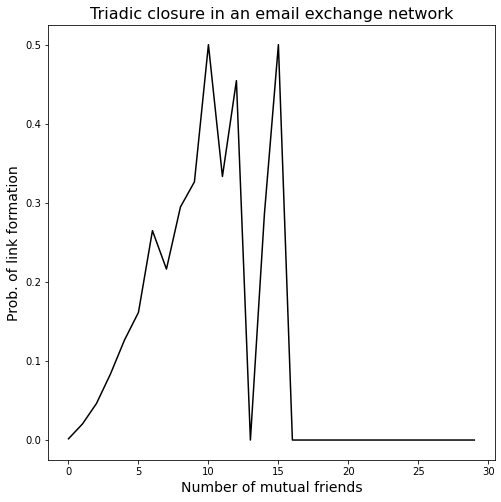

In [20]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()

# Run the algorithm on the whole dataset using rolling basis

In [21]:
def kossinets_watts_rolling_average(data):
    # the rolling use a period of 30 days (1 day = 86400 sec)
    max_t = math.floor(max(data['timestamp']) / (86400*30))
    # get 30 days value
    day_30 = 86400*30
    # initiate df to store data
    df = pd.DataFrame()
    data[data['timestamp'] < 8640000]
    for t in tqdm(range(max_t-1)):
        snap1 = data[data['timestamp'] < (t+1)*day_30]
        # sort by source, target
        snap1.sort_values(by = ['source', 'target'], ascending = True, inplace = True)

        snap2 = data[data['timestamp'] < (t+2)*day_30]
        
        # sort by source, target
        snap2.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
    
        snap1_result, snap1_structure = kossinets_watts(snap1)
        snap2_result, snap2_structure = kossinets_watts(snap2)
        
        new_tie_formed = get_added_ties(snap1_structure, snap2_structure)
        
        # get prob
        total_prob = {}
        # get total of nodes by mutual ties
        for node in snap1_result:
            for mutual in snap1_result[node]:
                num_node = len(snap1_result[node][mutual])
                if mutual in total_prob.keys():
                    total_prob[mutual] = total_prob[mutual] + num_node
                else:
                    total_prob[mutual] = num_node

        edge_form_prob = {}
        for node in new_tie_formed:
            for tie in new_tie_formed[node]:
                for k in snap1_result[node]:
                    if tie in snap1_result[node][k]:
                        if k in edge_form_prob.keys():
                            edge_form_prob[k] = edge_form_prob[k] + 1
                        else:
                            edge_form_prob[k] = 1
        
        # get k-t(k) dict for visualization
        k_tk_dict = {}
        for k in sorted(total_prob.keys()):
            if k not in edge_form_prob.keys():
                edge_form_prob[k] = 0
            k_tk_dict[k] = edge_form_prob[k] / total_prob[k]
        temp_df = pd.DataFrame.from_dict(k_tk_dict, orient='index', columns = ['tk'])
        # merge df
        df = pd.merge(df, temp_df, left_index = True, right_index = True, how = 'outer')
        df = pd.DataFrame(df.mean(axis = 1), columns = ['tk_bar'])
    return df

In [22]:
df = kossinets_watts_rolling_average(data)

In [23]:
df2 = df.rename_axis('k').reset_index()

In [24]:
# prep data for plot
# df = df.rename_axis('k').reset_index()
k = df2['k']
tk = df2['tk_bar']

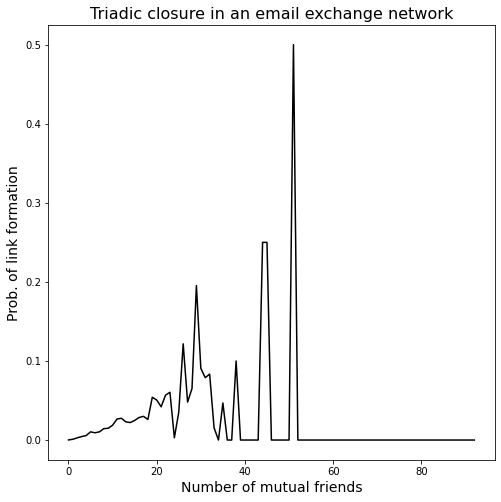

In [25]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()

In [26]:
# only plot the part that is relevant
df2 = df2.iloc[:15, :]

In [27]:
# prep data for plot
# df = df.rename_axis('k').reset_index()
k = df2['k']
tk = df2['tk_bar']

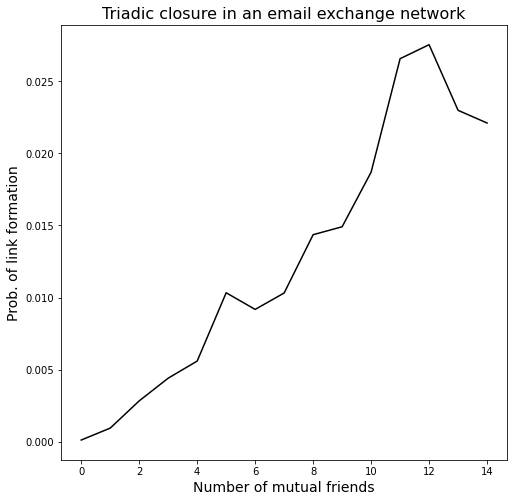

In [28]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()